In [ ]:
# Importing required libraries
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Step 1: Load the dataset (from CSV or any other file format)
# Assuming the dataset is in CSV format based on the image you've shared
df = pd.read_csv('/content/data.csv')

# Step 2: Preprocessing
# Remove 'id' column as it is not needed for classification
df.drop('id', axis=1, inplace=True)

# Encode the 'diagnosis' column (M = 1, B = 0)
df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': 0})

# Separate features and target
X = df.drop('diagnosis', axis=1)  # Features
y = df['diagnosis']  # Target

# Step 3: Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 4: Apply PCA to extract signal components (Danger, Safe, Novelty)
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

# Assign PCA components to the signals
ss = X_pca[:, 2]  # Safe Signal (smallest component)
ds = X_pca[:, 1]  # Danger Signal (second largest component)
ns = X_pca[:, 0]  # Novelty Signal (largest component)

# Step 5: Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=42)

# Signal Fusion Function (weight initialization)
def signal_fusion(ss, ds, w11=1, w12=1, w21=1, w22=1):
    csm = w11 * ss + w12 * ds  # Cumulative signal matrix (csm)
    k = w21 * ss + w22 * ds  # Anomalous signal (k)
    return csm, k

# DC Algorithm
class DendriticCell:
    def __init__(self, lifespan=10):
        self.lifespan = lifespan
        self.csm = 0
        self.k = 0

    def process_signal(self, ss, ds, w11, w12, w21, w22):
        # Signal fusion
        csm, k = signal_fusion(ss, ds, w11, w12, w21, w22)
        # Decrease lifespan by csm
        self.lifespan -= csm
        # Update internal signals
        self.csm += csm
        self.k += k
        return self.lifespan

    def is_mature(self):
        return self.lifespan <= 0

# TC Algorithm
class TCell:
    def __init__(self, threshold=5):
        self.k = 0  # Anomalous signal
        self.threshold = threshold  # Classification threshold

    def process_antigen(self, csm, ns):
        self.k += csm + ns

    def classify_antigen(self):
        if self.k > self.threshold:
            return 1  # Anomalous (Malignant)
        else:
            return 0  # Normal (Benign)

# Immune optimization strategy using gradient descent
def optimize_weights(X_train, y_train, iterations=100, alpha=0.01):
    w11, w12, w21, w22 = 1, 1, 1, 1  # Initialize weights
    for iteration in range(iterations):
        total_error = 0
        for i in range(X_train.shape[0]):
            # Extract Safe Signal and Danger Signal
            ss, ds, ns = X_train[i, 2], X_train[i, 1], X_train[i, 0]

            # Initialize DC and TC
            dc = DendriticCell()
            tc = TCell()

            # Process signals
            while not dc.is_mature():
                dc.process_signal(ss, ds, w11, w12, w21, w22)

            # If mature, classify antigen using TC
            tc.process_antigen(dc.csm, ns)
            prediction = tc.classify_antigen()

            # Calculate error (simple error for optimization)
            error = prediction - y_train[i]
            total_error += error**2

            # Gradient descent to update weights
            w11 -= alpha * error * ss
            w12 -= alpha * error * ds
            w21 -= alpha * error * ss
            w22 -= alpha * error * ds

        print(f"Iteration {iteration + 1}: Total Error: {total_error}")
    return w11, w12, w21, w22

# Final Classification Function
def classify(X_test, w11, w12, w21, w22):
    predictions = []
    for i in range(X_test.shape[0]):
        # Extract Safe Signal and Danger Signal
        ss, ds, ns = X_test[i, 2], X_test[i, 1], X_test[i, 0]

        # Initialize DC and TC
        dc = DendriticCell()
        tc = TCell()

        # Process signals
        while not dc.is_mature():
            dc.process_signal(ss, ds, w11, w12, w21, w22)

        # Classify antigen using TC
        tc.process_antigen(dc.csm, ns)
        prediction = tc.classify_antigen()
        predictions.append(prediction)
    return np.array(predictions)

# Train the model and evaluate performance
# Optimize the weights using training data
w11, w12, w21, w22 = optimize_weights(X_train, y_train, iterations=100, alpha=0.01)

# Classify the test data
y_pred = classify(X_test, w11, w12, w21, w22)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")


/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:1050: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:1055: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:1075: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


ValueError: Input X contains NaN.
PCA does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer

# Step 1: Load the dataset (from CSV or any other file format)
df = pd.read_csv('/content/data.csv')

# Step 2: Preprocessing
# Remove 'id' column as it is not needed for classification
df.drop('id', axis=1, inplace=True)

# Encode the 'diagnosis' column (M = 1, B = 0)
df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': 0})

# Separate features and target
X = df.drop('diagnosis', axis=1)  # Features
y = df['diagnosis']  # Target

# Step 3: Handle missing values by imputing (replace NaNs with the mean of the column)
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Step 4: Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Step 5: Apply PCA to extract signal components (Danger, Safe, Novelty)
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

# Assign PCA components to the signals
ss = X_pca[:, 2]  # Safe Signal (smallest component)
ds = X_pca[:, 1]  # Danger Signal (second largest component)
ns = X_pca[:, 0]  # Novelty Signal (largest component)

# Step 6: Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=42)

# Signal Fusion Function (weight initialization)
def signal_fusion(ss, ds, w11=1, w12=1, w21=1, w22=1):
    csm = w11 * ss + w12 * ds  # Cumulative signal matrix (csm)
    k = w21 * ss + w22 * ds  # Anomalous signal (k)
    return csm, k

# DC Algorithm
class DendriticCell:
    def __init__(self, lifespan=10):
        self.lifespan = lifespan
        self.csm = 0
        self.k = 0

    def process_signal(self, ss, ds, w11, w12, w21, w22):
        # Signal fusion
        csm, k = signal_fusion(ss, ds, w11, w12, w21, w22)
        # Decrease lifespan by csm
        self.lifespan -= csm
        # Update internal signals
        self.csm += csm
        self.k += k
        return self.lifespan

    def is_mature(self):
        return self.lifespan <= 0

# TC Algorithm
class TCell:
    def __init__(self, threshold=5):
        self.k = 0  # Anomalous signal
        self.threshold = threshold  # Classification threshold

    def process_antigen(self, csm, ns):
        self.k += csm + ns

    def classify_antigen(self):
        if self.k > self.threshold:
            return 1  # Anomalous (Malignant)
        else:
            return 0  # Normal (Benign)

# Immune optimization strategy using gradient descent
def optimize_weights(X_train, y_train, iterations=100, alpha=0.01):
    w11, w12, w21, w22 = 1, 1, 1, 1  # Initialize weights
    for iteration in range(iterations):
        total_error = 0
        for i in range(X_train.shape[0]):
            # Extract Safe Signal and Danger Signal
            ss, ds, ns = X_train[i, 2], X_train[i, 1], X_train[i, 0]

            # Initialize DC and TC
            dc = DendriticCell()
            tc = TCell()

            # Process signals
            while not dc.is_mature():
                dc.process_signal(ss, ds, w11, w12, w21, w22)

            # If mature, classify antigen using TC
            tc.process_antigen(dc.csm, ns)
            prediction = tc.classify_antigen()

            # Calculate error (simple error for optimization)
            error = prediction - y_train[i]
            total_error += error**2

            # Gradient descent to update weights
            w11 -= alpha * error * ss
            w12 -= alpha * error * ds
            w21 -= alpha * error * ss
            w22 -= alpha * error * ds

        print(f"Iteration {iteration + 1}: Total Error: {total_error}")
    return w11, w12, w21, w22

# Final Classification Function
def classify(X_test, w11, w12, w21, w22):
    predictions = []
    for i in range(X_test.shape[0]):
        # Extract Safe Signal and Danger Signal
        ss, ds, ns = X_test[i, 2], X_test[i, 1], X_test[i, 0]

        # Initialize DC and TC
        dc = DendriticCell()
        tc = TCell()

        # Process signals
        while not dc.is_mature():
            dc.process_signal(ss, ds, w11, w12, w21, w22)

        # Classify antigen using TC
        tc.process_antigen(dc.csm, ns)
        prediction = tc.classify_antigen()
        predictions.append(prediction)
    return np.array(predictions)

# Train the model and evaluate performance
# Optimize the weights using training data
w11, w12, w21, w22 = optimize_weights(X_train, y_train, iterations=100, alpha=0.01)

# Classify the test data
y_pred = classify(X_test, w11, w12, w21, w22)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")


/usr/local/lib/python3.10/dist-packages/sklearn/impute/_base.py:558: UserWarning: Skipping features without any observed values: ['Unnamed: 32']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


KeyboardInterrupt: 

17/9/24

In [ ]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer

# Step 1: Load the dataset (from CSV or any other file format)
df = pd.read_csv('/content/data.csv')

# Step 2: Preprocessing
# Drop 'Unnamed: 32' column if it exists (this column has no values)
df = df.drop(columns=['Unnamed: 32'], errors='ignore')

# Remove 'id' column as it is not needed for classification
df.drop('id', axis=1, inplace=True)

# Encode the 'diagnosis' column (M = 1, B = 0)
df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': 0})

# Separate features and target
X = df.drop('diagnosis', axis=1)  # Features
y = df['diagnosis']  # Target

# Step 3: Handle missing values by imputing (replace NaNs with the mean of the column)
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Step 4: Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Step 5: Apply PCA to extract signal components (Danger, Safe, Novelty)
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

# Ensure the signals are assigned based on explained variance order
ss, ds, ns = X_pca[:, 2], X_pca[:, 1], X_pca[:, 0]

# Step 6: Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=42)

# Signal Fusion Function (weight initialization)
def signal_fusion(ss, ds, w11=1, w12=1, w21=1, w22=1):
    csm = w11 * ss + w12 * ds  # Cumulative signal matrix (csm)
    k = w21 * ss + w22 * ds  # Anomalous signal (k)
    return csm, k

# DC Algorithm
class DendriticCell:
    def __init__(self, lifespan=10):
        self.lifespan = lifespan
        self.csm = 0
        self.k = 0

    def process_signal(self, ss, ds, w11, w12, w21, w22):
        # Signal fusion
        csm, k = signal_fusion(ss, ds, w11, w12, w21, w22)
        # Decrease lifespan by csm
        self.lifespan -= np.abs(csm)  # Avoid negative lifespan
        # Update internal signals
        self.csm += csm
        self.k += k
        return self.lifespan

    def is_mature(self):
        return self.lifespan <= 0

# TC Algorithm
class TCell:
    def __init__(self, threshold=5):
        self.k = 0  # Anomalous signal
        self.threshold = threshold  # Classification threshold

    def process_antigen(self, csm, ns):
        self.k += csm + ns

    def classify_antigen(self):
        return 1 if self.k > self.threshold else 0  # Classify based on threshold

# Gradient Descent Optimization for Weights
# Immune optimization strategy using gradient descent
def optimize_weights(X_train, y_train, iterations=100, alpha=0.01):
    w11, w12, w21, w22 = 1, 1, 1, 1  # Initialize weights
    for iteration in range(iterations):
        total_error = 0
        for i in range(X_train.shape[0]):
            # Extract Safe Signal and Danger Signal
            ss, ds, ns = X_train[i, 2], X_train[i, 1], X_train[i, 0]

            # Initialize DC and TC
            dc = DendriticCell()
            tc = TCell()

            # Process signals
            while not dc.is_mature():
                dc.process_signal(ss, ds, w11, w12, w21, w22)

            # If mature, classify antigen using TC
            tc.process_antigen(dc.csm, ns)
            prediction = tc.classify_antigen()

            # Calculate error (simple error for optimization)
            error = prediction - y_train.iloc[i] # Use .iloc to access elements by integer index
            total_error += error**2

            # Gradient descent to update weights
            w11 -= alpha * error * ss
            w12 -= alpha * error * ds
            w21 -= alpha * error * ss
            w22 -= alpha * error * ds

        print(f"Iteration {iteration + 1}: Total Error: {total_error}")
    return w11, w12, w21, w22

# Final Classification Function
def classify(X_test, w11, w12, w21, w22):
    predictions = []
    for i in range(X_test.shape[0]):
        ss, ds, ns = X_test[i, 2], X_test[i, 1], X_test[i, 0]

        # Initialize DC and TC
        dc = DendriticCell()
        tc = TCell()

        # Process signals
        while not dc.is_mature():
            dc.process_signal(ss, ds, w11, w12, w21, w22)

        # Classify antigen using TC
        tc.process_antigen(dc.csm, ns)
        prediction = tc.classify_antigen()
        predictions.append(prediction)
    return np.array(predictions)

# Train the model and evaluate performance
w11, w12, w21, w22 = optimize_weights(X_train, y_train, iterations=100, alpha=0.01)

# Classify the test data
y_pred = classify(X_test, w11, w12, w21, w22)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")


Iteration 1: Total Error: 204
Iteration 2: Total Error: 201
Iteration 3: Total Error: 192
Iteration 4: Total Error: 199
Iteration 5: Total Error: 191
Iteration 6: Total Error: 190
Iteration 7: Total Error: 198
Iteration 8: Total Error: 196
Iteration 9: Total Error: 199
Iteration 10: Total Error: 198
Iteration 11: Total Error: 189
Iteration 12: Total Error: 200
Iteration 13: Total Error: 204
Iteration 14: Total Error: 186
Iteration 15: Total Error: 193
Iteration 16: Total Error: 197
Iteration 17: Total Error: 187
Iteration 18: Total Error: 195
Iteration 19: Total Error: 192
Iteration 20: Total Error: 196
Iteration 21: Total Error: 192
Iteration 22: Total Error: 190
Iteration 23: Total Error: 199
Iteration 24: Total Error: 198
Iteration 25: Total Error: 195
Iteration 26: Total Error: 194
Iteration 27: Total Error: 188
Iteration 28: Total Error: 197
Iteration 29: Total Error: 198
Iteration 30: Total Error: 198
Iteration 31: Total Error: 199
Iteration 32: Total Error: 198
Iteration 33: Tot

Part-2 17/9/24

In [ ]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer

# Step 1: Load the dataset
df = pd.read_csv('/content/data.csv')

# Step 2: Preprocessing
df.drop(['id', 'Unnamed: 32'], axis=1, inplace=True)  # Drop ID and unwanted column
df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': 0})  # Encode diagnosis (M = 1, B = 0)

# Separate features and target
X = df.drop('diagnosis', axis=1)
y = df['diagnosis']

# Handle missing values by imputing with the mean
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Apply PCA to extract more components for better signal coverage
pca = PCA(n_components=5)  # Increased to 5 components for better signal capture
X_pca = pca.fit_transform(X_scaled)

# Assign PCA components to the signals
ss = X_pca[:, 3]  # Safe Signal (smallest)
ds = X_pca[:, 2]  # Danger Signal (second smallest)
ns = X_pca[:, 1]  # Novelty Signal (largest)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=42)

# Signal Fusion Function (weight initialization)
def signal_fusion(ss, ds, w11, w12, w21, w22):
    csm = w11 * ss + w12 * ds  # Cumulative signal matrix (csm)
    k = w21 * ss + w22 * ds    # Anomalous signal (k)
    return csm, k

# DC Algorithm
class DendriticCell:
    def __init__(self, lifespan=10):
        self.lifespan = lifespan
        self.csm = 0
        self.k = 0

    def process_signal(self, ss, ds, w11, w12, w21, w22):
        csm, k = signal_fusion(ss, ds, w11, w12, w21, w22)
        self.lifespan -= csm
        self.csm += csm
        self.k += k
        return self.lifespan

    def is_mature(self):
        return self.lifespan <= 0

# TC Algorithm
class TCell:
    def __init__(self, threshold=5):
        self.k = 0
        self.threshold = threshold

    def process_antigen(self, csm, ns):
        self.k += csm + ns

    def classify_antigen(self):
        return 1 if self.k > self.threshold else 0

# Optimized gradient descent with batch processing and early stopping
# Optimized gradient descent with batch processing and early stopping
def optimize_weights(X_train, y_train, iterations=50, alpha=0.001, batch_size=16):
    w11, w12, w21, w22 = np.random.rand(4)  # Random weight initialization
    n = X_train.shape[0]

    for iteration in range(iterations):
        total_error = 0

        # Batch Gradient Descent
        for start in range(0, n, batch_size):
            end = start + batch_size
            batch_X = X_train[start:end]
            batch_y = y_train[start:end]

            batch_error = 0
            for i in range(batch_X.shape[0]):
                ss, ds, ns = batch_X[i, 3], batch_X[i, 2], batch_X[i, 1]
                dc = DendriticCell()
                tc = TCell()

                # Process signals
                while not dc.is_mature():
                    dc.process_signal(ss, ds, w11, w12, w21, w22)

                # Classify antigen using TC
                tc.process_antigen(dc.csm, ns)
                prediction = tc.classify_antigen()

                # Calculate error
                # Use .iloc to access elements by integer index in the batch
                error = prediction - batch_y.iloc[i]
                batch_error += error**2

                # Update weights using gradient descent
                w11 -= alpha * error * ss
                w12 -= alpha * error * ds
                w21 -= alpha * error * ss
                w22 -= alpha * error * ds

            total_error += batch_error

        # Print iteration results
        print(f"Iteration {iteration + 1}: Total Error: {total_error}")

    return w11, w12, w21, w22

# Final Classification Function
def classify(X_test, w11, w12, w21, w22):
    predictions = []
    for i in range(X_test.shape[0]):
        ss, ds, ns = X_test[i, 3], X_test[i, 2], X_test[i, 1]
        dc = DendriticCell()
        tc = TCell()

        # Process signals
        while not dc.is_mature():
            dc.process_signal(ss, ds, w11, w12, w21, w22)

        # Classify antigen using TC
        tc.process_antigen(dc.csm, ns)
        prediction = tc.classify_antigen()
        predictions.append(prediction)
    return np.array(predictions)

# Train the model and evaluate performance
w11, w12, w21, w22 = optimize_weights(X_train, y_train, iterations=50, alpha=0.001, batch_size=16)

# Classify the test data
y_pred = classify(X_test, w11, w12, w21, w22)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")


KeyboardInterrupt: 

18/9/24

In [ ]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer

# Step 1: Load the dataset
df = pd.read_csv('/content/data.csv')

# Step 2: Preprocessing
df.drop(['id', 'Unnamed: 32'], axis=1, inplace=True)  # Drop ID and unwanted column
df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': 0})  # Encode diagnosis (M = 1, B = 0)

# Separate features and target
X = df.drop('diagnosis', axis=1).values  # Convert to NumPy array explicitly
y = df['diagnosis'].values  # Convert to NumPy array explicitly

# Handle missing values by imputing with the mean
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Apply PCA to extract more components for better signal coverage
pca = PCA(n_components=5)  # Increased to 5 components for better signal capture
X_pca = pca.fit_transform(X_scaled)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=42)

# Signal Fusion Function (weight initialization)
def signal_fusion(ss, ds, w11, w12, w21, w22):
    csm = w11 * ss + w12 * ds  # Cumulative signal matrix (csm)
    k = w21 * ss + w22 * ds    # Anomalous signal (k)
    return csm, k

# DC Algorithm
class DendriticCell:
    def __init__(self, lifespan=5):  # Reduced lifespan for quicker termination
        self.lifespan = lifespan
        self.csm = 0
        self.k = 0

    def process_signal(self, ss, ds, w11, w12, w21, w22):
        csm, k = signal_fusion(ss, ds, w11, w12, w21, w22)
        self.lifespan -= abs(csm)  # Ensure the lifespan decreases faster
        self.csm += csm
        self.k += k
        return self.lifespan

    def is_mature(self):
        return self.lifespan <= 0

# TC Algorithm
class TCell:
    def __init__(self, threshold=5):
        self.k = 0
        self.threshold = threshold

    def process_antigen(self, csm, ns):
        self.k += csm + ns

    def classify_antigen(self):
        # Simplified binary classification based on threshold
        return 1 if self.k > self.threshold else 0

# Dynamic Learning Rate (Immune Non-Linear Optimization)
def immune_non_linear_optimization(learning_rate):
    return learning_rate * np.random.rand()

# Optimized gradient descent with batch processing and dynamic learning rate
def optimize_weights(X_train, y_train, iterations=10, alpha=0.001, batch_size=16):
    w11, w12, w21, w22 = np.random.rand(4)  # Random weight initialization
    n = X_train.shape[0]

    print("Starting optimization process...")

    for iteration in range(iterations):
        total_error = 0
        print(f"\nIteration {iteration + 1}:")

        # Dynamic learning rate adjustment
        alpha = immune_non_linear_optimization(alpha)
        print(f"Adjusted Learning Rate: {alpha}")

        # Batch Gradient Descent
        for start in range(0, n, batch_size):
            end = start + batch_size
            batch_X = X_train[start:end]
            batch_y = y_train[start:end]

            batch_error = 0
            for i in range(batch_X.shape[0]):
                ss, ds, ns = batch_X[i, 3], batch_X[i, 2], batch_X[i, 1]
                dc = DendriticCell(lifespan=5)  # Adjusted lifespan
                tc = TCell()

                # Process signals
                step = 0  # Step counter for debugging
                while not dc.is_mature():
                    step += 1
                    dc.process_signal(ss, ds, w11, w12, w21, w22)
                    if step > 10:  # Prevent excessive looping
                        print(f"Breaking out of signal processing after 10 steps for data point {i}")
                        break

                # Classify antigen using TC
                tc.process_antigen(dc.csm, ns)
                prediction = tc.classify_antigen()

                # Calculate error (use simple difference between predicted and actual)
                error = prediction - batch_y[i]
                batch_error += error**2

                # Update weights using gradient descent
                w11 -= alpha * error * ss
                w12 -= alpha * error * ds
                w21 -= alpha * error * ss
                w22 -= alpha * error * ds

            total_error += batch_error
            print(f"Batch {start // batch_size + 1}: Batch Error = {batch_error}")

        print(f"Iteration {iteration + 1}: Total Error = {total_error}")

    print("Optimization completed.")
    return w11, w12, w21, w22

# Final Classification Function
def classify(X_test, w11, w12, w21, w22):
    predictions = []
    for i in range(X_test.shape[0]):
        ss, ds, ns = X_test[i, 3], X_test[i, 2], X_test[i, 1]
        dc = DendriticCell(lifespan=5)  # Reduced lifespan
        tc = TCell()

        # Process signals
        step = 0
        while not dc.is_mature():
            step += 1
            dc.process_signal(ss, ds, w11, w12, w21, w22)
            if step > 10:  # Safety measure to prevent infinite loops
                print(f"Breaking out of signal processing after 10 steps for test data point {i}")
                break

        # Classify antigen using TC
        tc.process_antigen(dc.csm, ns)
        prediction = tc.classify_antigen()
        predictions.append(prediction)
    return np.array(predictions)

# Train the model and evaluate performance
w11, w12, w21, w22 = optimize_weights(X_train, y_train, iterations=10, alpha=0.001, batch_size=16)

# Classify the test data
y_pred = classify(X_test, w11, w12, w21, w22)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy * 100:.2f}%")


Starting optimization process...

Iteration 1:
Adjusted Learning Rate: 0.0008685009275819302
Breaking out of signal processing after 10 steps for data point 0
Breaking out of signal processing after 10 steps for data point 1
Breaking out of signal processing after 10 steps for data point 2
Breaking out of signal processing after 10 steps for data point 3
Breaking out of signal processing after 10 steps for data point 4
Breaking out of signal processing after 10 steps for data point 5
Breaking out of signal processing after 10 steps for data point 6
Breaking out of signal processing after 10 steps for data point 7
Breaking out of signal processing after 10 steps for data point 8
Breaking out of signal processing after 10 steps for data point 9
Breaking out of signal processing after 10 steps for data point 10
Breaking out of signal processing after 10 steps for data point 11
Breaking out of signal processing after 10 steps for data point 12
Breaking out of signal processing after 10 ste

Output.csv

In [ ]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer

# Step 1: Load the dataset
df = pd.read_csv('/content/data.csv')

# Step 2: Preprocessing
df.drop(['id', 'Unnamed: 32'], axis=1, inplace=True)  # Drop ID and unwanted column
df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': 0})  # Encode diagnosis (M = 1, B = 0)

# Separate features and target
X = df.drop('diagnosis', axis=1).values  # Convert to NumPy array explicitly
y = df['diagnosis'].values  # Convert to NumPy array explicitly

# Handle missing values by imputing with the mean
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Apply PCA to extract more components for better signal coverage
pca = PCA(n_components=5)  # Increased to 5 components for better signal capture
X_pca = pca.fit_transform(X_scaled)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=42)

# Signal Fusion Function (weight initialization)
def signal_fusion(ss, ds, w11, w12, w21, w22):
    csm = w11 * ss + w12 * ds  # Cumulative signal matrix (csm)
    k = w21 * ss + w22 * ds    # Anomalous signal (k)
    return csm, k

# DC Algorithm
class DendriticCell:
    def __init__(self, lifespan=5):  # Reduced lifespan for quicker termination
        self.lifespan = lifespan
        self.csm = 0
        self.k = 0

    def process_signal(self, ss, ds, w11, w12, w21, w22):
        csm, k = signal_fusion(ss, ds, w11, w12, w21, w22)
        self.lifespan -= abs(csm)  # Ensure the lifespan decreases faster
        self.csm += csm
        self.k += k
        return self.lifespan

    def is_mature(self):
        return self.lifespan <= 0

# TC Algorithm
class TCell:
    def __init__(self, threshold=5):
        self.k = 0
        self.threshold = threshold

    def process_antigen(self, csm, ns):
        self.k += csm + ns

    def classify_antigen(self):
        return 1 if self.k > self.threshold else 0

# Optimized gradient descent with batch processing and dynamic learning rate
def optimize_weights(X_train, y_train, iterations=10, alpha=0.001, batch_size=16):
    w11, w12, w21, w22 = np.random.rand(4)  # Random weight initialization
    n = X_train.shape[0]

    print("Starting optimization process...")

    for iteration in range(iterations):
        total_error = 0
        print(f"\nIteration {iteration + 1}:")

        # Batch Gradient Descent
        for start in range(0, n, batch_size):
            end = start + batch_size
            batch_X = X_train[start:end]
            batch_y = y_train[start:end]

            batch_error = 0
            for i in range(batch_X.shape[0]):
                ss, ds, ns = batch_X[i, 3], batch_X[i, 2], batch_X[i, 1]
                dc = DendriticCell(lifespan=5)  # Adjusted lifespan
                tc = TCell()

                # Process signals
                step = 0
                while not dc.is_mature():
                    step += 1
                    dc.process_signal(ss, ds, w11, w12, w21, w22)
                    if step > 10:  # Prevent excessive looping
                        break

                # Classify antigen using TC
                tc.process_antigen(dc.csm, ns)
                prediction = tc.classify_antigen()

                # Calculate error (use simple difference between predicted and actual)
                error = prediction - batch_y[i]
                batch_error += error**2

                # Update weights using gradient descent
                w11 -= alpha * error * ss
                w12 -= alpha * error * ds
                w21 -= alpha * error * ss
                w22 -= alpha * error * ds

            total_error += batch_error
        print(f"Iteration {iteration + 1}: Total Error = {total_error}")

    print("Optimization completed.")
    return w11, w12, w21, w22

# Final Classification Function
def classify(X_test, w11, w12, w21, w22):
    predictions = []
    for i in range(X_test.shape[0]):
        ss, ds, ns = X_test[i, 3], X_test[i, 2], X_test[i, 1]
        dc = DendriticCell(lifespan=5)
        tc = TCell()

        # Process signals
        step = 0
        while not dc.is_mature():
            step += 1
            dc.process_signal(ss, ds, w11, w12, w21, w22)
            if step > 10:  # Safety measure to prevent infinite loops
                break

        # Classify antigen using TC
        tc.process_antigen(dc.csm, ns)
        prediction = tc.classify_antigen()
        predictions.append(prediction)
    return np.array(predictions)

# Train the model and evaluate performance
w11, w12, w21, w22 = optimize_weights(X_train, y_train, iterations=10, alpha=0.001, batch_size=16)

# Classify the test data
y_pred = classify(X_test, w11, w12, w21, w22)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy * 100:.2f}%")

# Step 3: Create the final DataFrame with all the required columns

# Convert the predictions and actual values to M/B format
predicted_outcome_M_b = np.where(y_pred == 1, 'M', 'B')  # Map 1 -> 'M', 0 -> 'B'
actual_outcome_M_b = np.where(y_test == 1, 'M', 'B')

# Create the final DataFrame
output_df = pd.DataFrame({
    'Predicted_Outcome_Binary': y_pred,
    'Predicted_Outcome_M_B': predicted_outcome_M_b,
    'Actual_Diagnosis_Binary': y_test,
    'Actual_Diagnosis_M_B': actual_outcome_M_b
})

# Save the final DataFrame to a CSV file
output_df.to_csv('output_predictions.csv', index=False)

print("The final predictions have been saved to 'output_predictions.csv'.")


Starting optimization process...

Iteration 1:
Iteration 1: Total Error = 189

Iteration 2:
Iteration 2: Total Error = 179

Iteration 3:
Iteration 3: Total Error = 171

Iteration 4:
Iteration 4: Total Error = 153

Iteration 5:
Iteration 5: Total Error = 146

Iteration 6:
Iteration 6: Total Error = 144

Iteration 7:
Iteration 7: Total Error = 144

Iteration 8:
Iteration 8: Total Error = 141

Iteration 9:
Iteration 9: Total Error = 140

Iteration 10:
Iteration 10: Total Error = 138
Optimization completed.

Accuracy: 65.50%
The final predictions have been saved to 'output_predictions.csv'.


TRY--3

In [ ]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.impute import SimpleImputer

# Step 1: Load the dataset
df = pd.read_csv('/content/data.csv')

# Step 2: Preprocessing
df.drop(['id', 'Unnamed: 32'], axis=1, inplace=True)  # Drop ID and unwanted column
df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': 0})  # Encode diagnosis (M = 1, B = 0)

# Separate features and target
X = df.drop('diagnosis', axis=1).values  # Convert to NumPy array explicitly
y = df['diagnosis'].values  # Convert to NumPy array explicitly

# Handle missing values by imputing with the mean
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Apply PCA to extract more components for better signal coverage
pca = PCA(n_components=5)  # Increased to 5 components for better signal capture
X_pca = pca.fit_transform(X_scaled)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=42)

# Signal Fusion Function (weight initialization)
def signal_fusion(ss, ds, w11, w12, w21, w22):
    csm = w11 * ss + w12 * ds  # Cumulative signal matrix (csm)
    k = w21 * ss + w22 * ds    # Anomalous signal (k)
    return csm, k

# DC Algorithm
class DendriticCell:
    def __init__(self, lifespan=5):  # Reduced lifespan for quicker termination
        self.lifespan = lifespan
        self.csm = 0
        self.k = 0

    def process_signal(self, ss, ds, w11, w12, w21, w22):
        csm, k = signal_fusion(ss, ds, w11, w12, w21, w22)
        self.lifespan -= abs(csm)  # Ensure the lifespan decreases faster
        self.csm += csm
        self.k += k
        return self.lifespan

    def is_mature(self):
        return self.lifespan <= 0

# TC Algorithm
class TCell:
    def __init__(self, threshold=5):
        self.k = 0
        self.threshold = threshold

    def process_antigen(self, csm, ns):
        self.k += csm + ns

    def classify_antigen(self):
        return 1 if self.k > self.threshold else 0

# Optimized gradient descent with batch processing and dynamic learning rate
def optimize_weights(X_train, y_train, iterations=10, alpha=0.001, batch_size=16):
    w11, w12, w21, w22 = np.random.rand(4)  # Random weight initialization
    n = X_train.shape[0]

    print("Starting optimization process...")

    for iteration in range(iterations):
        total_error = 0
        print(f"\nIteration {iteration + 1}:")

        # Batch Gradient Descent
        for start in range(0, n, batch_size):
            end = start + batch_size
            batch_X = X_train[start:end]
            batch_y = y_train[start:end]

            batch_error = 0
            for i in range(batch_X.shape[0]):
                ss, ds, ns = batch_X[i, 3], batch_X[i, 2], batch_X[i, 1]
                dc = DendriticCell(lifespan=5)  # Adjusted lifespan
                tc = TCell()

                # Process signals
                step = 0
                while not dc.is_mature():
                    step += 1
                    dc.process_signal(ss, ds, w11, w12, w21, w22)
                    if step > 10:  # Prevent excessive looping
                        break

                # Classify antigen using TC
                tc.process_antigen(dc.csm, ns)
                prediction = tc.classify_antigen()

                # Calculate error (use simple difference between predicted and actual)
                error = prediction - batch_y[i]
                batch_error += error**2

                # Update weights using gradient descent
                w11 -= alpha * error * ss
                w12 -= alpha * error * ds
                w21 -= alpha * error * ss
                w22 -= alpha * error * ds

            total_error += batch_error
        print(f"Iteration {iteration + 1}: Total Error = {total_error}")

    print("Optimization completed.")
    return w11, w12, w21, w22

# Final Classification Function
def classify(X_test, w11, w12, w21, w22):
    predictions = []
    for i in range(X_test.shape[0]):
        ss, ds, ns = X_test[i, 3], X_test[i, 2], X_test[i, 1]
        dc = DendriticCell(lifespan=5)
        tc = TCell()

        # Process signals
        step = 0
        while not dc.is_mature():
            step += 1
            dc.process_signal(ss, ds, w11, w12, w21, w22)
            if step > 10:  # Safety measure to prevent infinite loops
                break

        # Classify antigen using TC
        tc.process_antigen(dc.csm, ns)
        prediction = tc.classify_antigen()
        predictions.append(prediction)
    return np.array(predictions)

# Train the model and evaluate performance
w11, w12, w21, w22 = optimize_weights(X_train, y_train, iterations=10, alpha=0.001, batch_size=16)

# Classify the test data
y_pred = classify(X_test, w11, w12, w21, w22)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy * 100:.2f}%")

# Confusion Matrix and Classification Report
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Step 3: Create the final DataFrame with all the required columns

# Convert the predictions and actual values to M/B format
predicted_outcome_M_b = np.where(y_pred == 1, 'M', 'B')  # Map 1 -> 'M', 0 -> 'B'
actual_outcome_M_b = np.where(y_test == 1, 'M', 'B')

# Create the final DataFrame
output_df = pd.DataFrame({
    'Predicted_Outcome_Binary': y_pred,
    'Predicted_Outcome_M_B': predicted_outcome_M_b,
    'Actual_Diagnosis_Binary': y_test,
    'Actual_Diagnosis_M_B': actual_outcome_M_b
})

# Save the final DataFrame to a CSV file
output_df.to_csv('output_predictions_1.csv', index=False)

print("The final predictions have been saved to 'output_predictions.csv'.")


Starting optimization process...

Iteration 1:
Iteration 1: Total Error = 191

Iteration 2:
Iteration 2: Total Error = 184

Iteration 3:
Iteration 3: Total Error = 168

Iteration 4:
Iteration 4: Total Error = 154

Iteration 5:
Iteration 5: Total Error = 147

Iteration 6:
Iteration 6: Total Error = 146

Iteration 7:
Iteration 7: Total Error = 145

Iteration 8:
Iteration 8: Total Error = 141

Iteration 9:
Iteration 9: Total Error = 139

Iteration 10:
Iteration 10: Total Error = 138
Optimization completed.

Accuracy: 65.50%

Confusion Matrix:
[[107   1]
 [ 58   5]]

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.99      0.78       108
           1       0.83      0.08      0.14        63

    accuracy                           0.65       171
   macro avg       0.74      0.54      0.46       171
weighted avg       0.72      0.65      0.55       171

The final predictions have been saved to 'output_predictions.csv'.


try 4 ( with the pseudocodes)

In [ ]:
import numpy as np
import pandas as pd

# Loading the dataset
data = pd.read_csv("/content/data.csv")

# Initialization
NAD = 5  # Number of DCs
NAG = len(data)  # Number of antigens (data points)
TK = 0.5  # Anomaly threshold for both DC and TC
iterations = 10  # Number of optimization iterations
wij = np.ones(4)  # Weights w11, w12, w21, w22 initialized to 1

# Signal columns (Danger signals 'ds', Safe signals 'ss')
ds = data['ds'].values
ss = data['ss'].values

# Initialization of DC and TC sets
class DC:
    def __init__(self):
        self.lifespan = 100
        self.csm = 0
        self.k = 0
        self.status = 'semimature'

class TC:
    def __init__(self):
        self.k = 0

def DCDiscrimination(DC, ds, ss, wij):
    k = wij[0] * ss + wij[1] * ds
    csm = wij[2] * ss + wij[3] * ds

    for i in range(NAD):
        DC.lifespan -= csm
        DC.csm += csm
        DC.k += k

    if DC.lifespan <= 0:
        DC.status = 'mature'
    else:
        DC.status = 'semimature'

    Ka = DC.k / (DC.csm + 1e-6)  # Anomaly value
    return DC, Ka

def TCDiscrimination(TC, ag, csm, ns):
    if ag == 'anomaly':
        TC.k += csm + ns
    if TC.k > TK:
        return 'anomaly'
    else:
        return 'normal'

def ImmuneOptimization(ag, TC, DC, ns, ds, ss, wij):
    # Error function calculation
    error_w11 = 2 * (ds - ss) * ds
    error_w12 = 2 * (ds - ss) * ss
    error_w21 = 2 * (ds - ss) * (2 * ds / (NAD * NAG))
    error_w22 = 2 * (ds - ss) * (2 * ss / (NAD * NAG))

    # Learning rate
    alpha1 = NAG**2 / (NAG**2 + NAD**2)
    alpha2 = NAG**2 / (NAG**2 + len(TC)**2)

    # Weight update
    wij[0] += alpha1 * error_w11
    wij[1] += alpha1 * error_w12
    wij[2] += alpha2 * error_w21
    wij[3] += alpha2 * error_w22

    return wij

# Main IO-dDCA process
for iteration in range(iterations):
    for i in range(NAG):
        ag = 'normal'
        ns = 0  # No novelty signal yet

        DCs = [DC() for _ in range(NAD)]  # Initialize DCs
        for dc in DCs:
            dc, Ka = DCDiscrimination(dc, ds[i], ss[i], wij)

            if Ka > TK:
                ag = 'anomaly'
                break

        TCs = [TC() for _ in range(NAD)]  # Initialize TCs
        for tc in TCs:
            ag_status = TCDiscrimination(tc, ag, dc.csm, ns)
            if ag_status == 'anomaly':
                break

        wij = ImmuneOptimization(ag, TCs, DCs, ns, ds[i], ss[i], wij)

# Post-process the results and save predictions
data['predicted_outcome_binary'] = [1 if x == 'anomaly' else 0 for x in ag]
data['predicted_outcome_M_B'] = ['M' if x == 1 else 'B' for x in data['predicted_outcome_binary']]
data['mapped_diagnosis_binary'] = data['diagnosis'].map({'M': 1, 'B': 0})
data['mapped_diagnosis_M_B'] = data['diagnosis']

data.to_csv('output_predictions.csv', index=False)
print("Optimization completed. Results saved to 'output_predictions.csv'.")


KeyError: 'ds'

In [ ]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.impute import SimpleImputer

# Step 1: Load the dataset
df = pd.read_csv('/content/data.csv')

# Step 2: Preprocessing
df.drop(['id', 'Unnamed: 32'], axis=1, inplace=True)  # Drop ID and unwanted column
df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': 0})  # Encode diagnosis (M = 1, B = 0)

# Separate features and target
X = df.drop('diagnosis', axis=1).values  # Convert to NumPy array explicitly
y = df['diagnosis'].values  # Convert to NumPy array explicitly

# Handle missing values by imputing with the mean
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Apply PCA to extract more components for better signal coverage
pca = PCA(n_components=5)  # Increased to 5 components for better signal capture
X_pca = pca.fit_transform(X_scaled)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=42)

# Signal Fusion Function (weight initialization)
def signal_fusion(ss, ds, w11, w12, w21, w22):
    csm = w11 * ss + w12 * ds  # Cumulative signal matrix (csm)
    k = w21 * ss + w22 * ds    # Anomalous signal (k)
    return csm, k

# DC Algorithm
class DendriticCell:
    def __init__(self, lifespan=5):  # Reduced lifespan for quicker termination
        self.lifespan = lifespan
        self.csm = 0
        self.k = 0

    def process_signal(self, ss, ds, w11, w12, w21, w22):
        csm, k = signal_fusion(ss, ds, w11, w12, w21, w22)
        self.lifespan -= abs(csm)  # Ensure the lifespan decreases faster
        self.csm += csm
        self.k += k
        return self.lifespan

    def is_mature(self):
        return self.lifespan <= 0

# TC Algorithm
class TCell:
    def __init__(self, threshold=5):
        self.k = 0
        self.threshold = threshold

    def process_antigen(self, csm, ns):
        self.k += csm + ns

    def classify_antigen(self):
        return 1 if self.k > self.threshold else 0

# Optimized gradient descent with batch processing and dynamic learning rate
def optimize_weights(X_train, y_train, iterations=10, alpha=0.001, batch_size=16):
    w11, w12, w21, w22 = np.random.rand(4)  # Random weight initialization
    n = X_train.shape[0]

    print("Starting optimization process...")

    for iteration in range(iterations):
        total_error = 0
        print(f"\nIteration {iteration + 1}:")

        # Batch Gradient Descent
        for start in range(0, n, batch_size):
            end = start + batch_size
            batch_X = X_train[start:end]
            batch_y = y_train[start:end]

            batch_error = 0
            for i in range(batch_X.shape[0]):
                ss, ds, ns = batch_X[i, 3], batch_X[i, 2], batch_X[i, 1]
                dc = DendriticCell(lifespan=5)  # Adjusted lifespan
                tc = TCell()

                # Process signals
                step = 0
                while not dc.is_mature():
                    step += 1
                    dc.process_signal(ss, ds, w11, w12, w21, w22)
                    if step > 10:  # Prevent excessive looping
                        break

                # Classify antigen using TC
                tc.process_antigen(dc.csm, ns)
                prediction = tc.classify_antigen()

                # Calculate error (use simple difference between predicted and actual)
                error = prediction - batch_y[i]
                batch_error += error**2

                # Update weights using gradient descent
                w11 -= alpha * error * ss
                w12 -= alpha * error * ds
                w21 -= alpha * error * ss
                w22 -= alpha * error * ds

            total_error += batch_error
        print(f"Iteration {iteration + 1}: Total Error = {total_error}")

    print("Optimization completed.")
    return w11, w12, w21, w22

# Final Classification Function
def classify(X_test, w11, w12, w21, w22):
    predictions = []
    for i in range(X_test.shape[0]):
        ss, ds, ns = X_test[i, 3], X_test[i, 2], X_test[i, 1]
        dc = DendriticCell(lifespan=5)
        tc = TCell()

        # Process signals
        step = 0
        while not dc.is_mature():
            step += 1
            dc.process_signal(ss, ds, w11, w12, w21, w22)
            if step > 10:  # Safety measure to prevent infinite loops
                break

        # Classify antigen using TC
        tc.process_antigen(dc.csm, ns)
        prediction = tc.classify_antigen()
        predictions.append(prediction)
    return np.array(predictions)

# Train the model and evaluate performance
w11, w12, w21, w22 = optimize_weights(X_train, y_train, iterations=10, alpha=0.001, batch_size=16)

# Classify the test data
y_pred = classify(X_test, w11, w12, w21, w22)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy * 100:.2f}%")

# Confusion Matrix and Classification Report
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Step 3: Create the final DataFrame with all the required columns

# Convert the predictions and actual values to M/B format
predicted_outcome_M_b = np.where(y_pred == 1, 'M', 'B')  # Map 1 -> 'M', 0 -> 'B'
actual_outcome_M_b = np.where(y_test == 1, 'M', 'B')

# Create the final DataFrame
output_df = pd.DataFrame({
    'Predicted_Outcome_Binary': y_pred,
    'Predicted_Outcome_M_B': predicted_outcome_M_b,
    'Actual_Diagnosis_Binary': y_test,
    'Actual_Diagnosis_M_B': actual_outcome_M_b
})

# Save the final DataFrame to a CSV file
output_df.to_csv('output_predictions.csv', index=False)

print("The final predictions have been saved to 'output_predictions.csv'.")


Starting optimization process...

Iteration 1:
Iteration 1: Total Error = 191

Iteration 2:
Iteration 2: Total Error = 177

Iteration 3:
Iteration 3: Total Error = 171

Iteration 4:
Iteration 4: Total Error = 155

Iteration 5:
Iteration 5: Total Error = 150

Iteration 6:
Iteration 6: Total Error = 148

Iteration 7:
Iteration 7: Total Error = 145

Iteration 8:
Iteration 8: Total Error = 143

Iteration 9:
Iteration 9: Total Error = 139

Iteration 10:
Iteration 10: Total Error = 138
Optimization completed.

Accuracy: 64.91%

Confusion Matrix:
[[107   1]
 [ 59   4]]

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.99      0.78       108
           1       0.80      0.06      0.12        63

    accuracy                           0.65       171
   macro avg       0.72      0.53      0.45       171
weighted avg       0.70      0.65      0.54       171

The final predictions have been saved to 'output_predictions.csv'.


In [ ]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.impute import SimpleImputer

# Step 1: Load the dataset
df = pd.read_csv('/content/data.csv')

# Step 2: Preprocessing
df.drop(['id', 'Unnamed: 32'], axis=1, inplace=True)  # Drop ID and unwanted column
df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': 0})  # Encode diagnosis (M = 1, B = 0)

# Separate features and target
X = df.drop('diagnosis', axis=1).values  # Convert to NumPy array explicitly
y = df['diagnosis'].values  # Convert to NumPy array explicitly

# Handle missing values by imputing with the mean
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Apply PCA to extract more components for better signal coverage
pca = PCA(n_components=5)  # Increased to 5 components for better signal capture
X_pca = pca.fit_transform(X_scaled)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=42)

# Signal Fusion Function (weight initialization)
def signal_fusion(ss, ds, w11, w12, w21, w22):
    csm = w11 * ss + w12 * ds  # Cumulative signal matrix (csm)
    k = w21 * ss + w22 * ds    # Anomalous signal (k)
    return csm, k

# DC Algorithm
class DendriticCell:
    def __init__(self, lifespan=5):  # Reduced lifespan for quicker termination
        self.lifespan = lifespan
        self.csm = 0
        self.k = 0

    def process_signal(self, ss, ds, w11, w12, w21, w22):
        csm, k = signal_fusion(ss, ds, w11, w12, w21, w22)
        self.lifespan -= abs(csm)  # Ensure the lifespan decreases faster
        self.csm += csm
        self.k += k
        return self.lifespan

    def is_mature(self):
        return self.lifespan <= 0

# TC Algorithm
class TCell:
    def __init__(self, threshold=5):
        self.k = 0
        self.threshold = threshold

    def process_antigen(self, csm, ns):
        self.k += csm + ns

    def classify_antigen(self):
        return 1 if self.k > self.threshold else 0

# Optimized gradient descent with batch processing and dynamic learning rate
def optimize_weights(X_train, y_train, iterations=10, alpha=0.001, batch_size=16):
    w11, w12, w21, w22 = np.random.rand(4)  # Random weight initialization
    n = X_train.shape[0]

    print("Starting optimization process...")

    for iteration in range(iterations):
        total_error = 0
        print(f"\nIteration {iteration + 1}:")

        # Batch Gradient Descent
        for start in range(0, n, batch_size):
            end = start + batch_size
            batch_X = X_train[start:end]
            batch_y = y_train[start:end]

            batch_error = 0
            for i in range(batch_X.shape[0]):
                ss, ds, ns = batch_X[i, 3], batch_X[i, 2], batch_X[i, 1]
                dc = DendriticCell(lifespan=5)  # Adjusted lifespan
                tc = TCell()

                # Process signals
                step = 0
                while not dc.is_mature():
                    step += 1
                    dc.process_signal(ss, ds, w11, w12, w21, w22)
                    if step > 10:  # Prevent excessive looping
                        break

                # Classify antigen using TC
                tc.process_antigen(dc.csm, ns)
                prediction = tc.classify_antigen()

                # Calculate error (use simple difference between predicted and actual)
                error = prediction - batch_y[i]
                batch_error += error**2

                # Update weights using gradient descent
                w11 -= alpha * error * ss
                w12 -= alpha * error * ds
                w21 -= alpha * error * ss
                w22 -= alpha * error * ds

            total_error += batch_error
        print(f"Iteration {iteration + 1}: Total Error = {total_error}")

    print("Optimization completed.")
    return w11, w12, w21, w22

# Final Classification Function
def classify(X_test, w11, w12, w21, w22):
    predictions = []
    for i in range(X_test.shape[0]):
        ss, ds, ns = X_test[i, 3], X_test[i, 2], 0
        dc = DendriticCell(lifespan=5)
        tc = TCell()

        # Process signals
        step = 0
        while not dc.is_mature():
            step += 1
            dc.process_signal(ss, ds, w11, w12, w21, w22)
            if step > 10:  # Safety measure to prevent infinite loops
                break

        # Classify antigen using TC
        tc.process_antigen(dc.csm, ns)
        prediction = tc.classify_antigen()
        predictions.append(prediction)
    return np.array(predictions)

# Prediction and storing results
y_pred = []
for i in range(len(X_test)):
    ds, ss, ns = X_test[i, 2], X_test[i, 3], 0
    anomaly_detected = False  # Flag to mark if anomaly is detected

    DCs = [DendriticCell() for _ in range(5)]
    for dc in DCs:
        dc, Ka = signal_fusion(ds, ss, 1, 1, 1, 1)
        if Ka > 0.5:  # If anomaly detected, no need to check further
            anomaly_detected = True
            break

    if anomaly_detected:
        y_pred.append(1)  # Append 1 for anomaly
    else:
        y_pred.append(0)  # Append 0 for normal

# Train the model and evaluate performance
w11, w12, w21, w22 = optimize_weights(X_train, y_train, iterations=10, alpha=0.001, batch_size=16)

# Classify the test data
y_pred = classify(X_test, w11, w12, w21, w22)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy * 100:.2f}%")

# Confusion Matrix and Classification Report
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Final Output and CSV Generation

# Convert predictions to a DataFrame
df_predictions = pd.DataFrame({
    'predicted_outcome_binary': y_pred,
    'predicted_outcome_M_B': ['M' if pred == 1 else 'B' for pred in y_pred],
    'mapped_diagnosis_binary': y_test,
    'mapped_diagnosis_M_B': ['M' if true == 1 else 'B' for true in y_test]
})

# Save predictions to a CSV file
df_predictions.to_csv('output_predictions.csv', index=False)
print("Optimization completed. Results saved to 'output_predictions.csv'.")


Starting optimization process...

Iteration 1:
Iteration 1: Total Error = 161

Iteration 2:
Iteration 2: Total Error = 155

Iteration 3:
Iteration 3: Total Error = 152

Iteration 4:
Iteration 4: Total Error = 146

Iteration 5:
Iteration 5: Total Error = 142

Iteration 6:
Iteration 6: Total Error = 140

Iteration 7:
Iteration 7: Total Error = 138

Iteration 8:
Iteration 8: Total Error = 137

Iteration 9:
Iteration 9: Total Error = 138

Iteration 10:
Iteration 10: Total Error = 139
Optimization completed.

Accuracy: 64.91%

Confusion Matrix:
[[108   0]
 [ 60   3]]

Classification Report:
              precision    recall  f1-score   support

           0       0.64      1.00      0.78       108
           1       1.00      0.05      0.09        63

    accuracy                           0.65       171
   macro avg       0.82      0.52      0.44       171
weighted avg       0.77      0.65      0.53       171

Optimization completed. Results saved to 'output_predictions.csv'.


In [ ]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.impute import SimpleImputer

# Load the dataset
df = pd.read_csv('/content/data.csv')
df.drop(['id', 'Unnamed: 32'], axis=1, inplace=True)  # Drop unwanted columns
df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': 0})  # Encode diagnosis (M = 1, B = 0)

# Preprocessing and feature extraction
X = df.drop('diagnosis', axis=1).values  # Features
y = df['diagnosis'].values  # Target

# Handle missing values and scaling
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# PCA for dimensionality reduction
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_scaled)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=42)

# DC and TC Class Initialization
class DC:
    def __init__(self, lifespan=100):
        self.lifespan = lifespan
        self.csm = 0
        self.k = 0
        self.status = 'semimature'

class TC:
    def __init__(self):
        self.k = 0

# DC Discrimination function
def DCDiscrimination(dc, ds, ss, wij):
    k = wij[0] * ss + wij[1] * ds
    csm = wij[2] * ss + wij[3] * ds
    dc.lifespan -= csm
    dc.csm += csm
    dc.k += k
    if dc.lifespan <= 0:
        dc.status = 'mature'
    Ka = dc.k / (dc.csm + 1e-6)  # Anomaly value
    return dc, Ka

# TC Discrimination function
def TCDiscrimination(tc, ag, csm, ns):
    if ag == 'anomaly':
        tc.k += csm + ns
    return 'anomaly' if tc.k > 0.5 else 'normal'

# Immune optimization
def ImmuneOptimization(ag, TCs, DCs, ns, ds, ss, wij):
    error_w11 = 2 * (ds - ss) * ds
    error_w12 = 2 * (ds - ss) * ss
    error_w21 = 2 * (ds - ss) * (2 * ds / len(DCs))
    error_w22 = 2 * (ds - ss) * (2 * ss / len(DCs))
    alpha = len(DCs)**2 / (len(DCs)**2 + len(TCs)**2)
    wij[0] += alpha * error_w11
    wij[1] += alpha * error_w12
    wij[2] += alpha * error_w21
    wij[3] += alpha * error_w22
    return wij

# Optimizing and classifying the test data
wij = np.ones(4)
for iteration in range(10):
    for i in range(len(X_train)):
        ds, ss, ns = X_train[i, 2], X_train[i, 3], 0
        DCs = [DC() for _ in range(5)]
        for dc in DCs:
            dc, Ka = DCDiscrimination(dc, ds, ss, wij)
            if Ka > 0.5:
                ag = 'anomaly'
                break
        TCs = [TC() for _ in range(5)]
        for tc in TCs:
            ag_status = TCDiscrimination(tc, ag, dc.csm, ns)
            if ag_status == 'anomaly':
                break
        wij = ImmuneOptimization(ag, TCs, DCs, ns, ds, ss, wij)
# Prediction and storing results
y_pred = []
for i in range(len(X_test)):
    ds, ss, ns = X_test[i, 2], X_test[i, 3], 0
    anomaly_detected = False  # Flag to mark if anomaly is detected

    DCs = [DC() for _ in range(5)]
    for dc in DCs:
        dc, Ka = DCDiscrimination(dc, ds, ss, wij)
        if Ka > 0.5:  # If anomaly detected, no need to check further
            anomaly_detected = True
            break

    if anomaly_detected:
        y_pred.append(1)  # Append 1 for anomaly
    else:
        y_pred.append(0)  # Append 0 for normal

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy * 100:.2f}%")

# Verify the length of y_pred and y_test
print("Length of y_pred:", len(y_pred))
print("Length of y_test:", len(y_test))

# Convert predictions to a DataFrame
df_predictions = pd.DataFrame({
    'predicted_outcome_binary': y_pred,
    'predicted_outcome_M_B': ['M' if pred == 1 else 'B' for pred in y_pred],
    'mapped_diagnosis_binary': y_test,
    'mapped_diagnosis_M_B': ['M' if true == 1 else 'B' for true in y_test]
})

# Save predictions to a CSV file
df_predictions.to_csv('output_predictions.csv', index=False)
print("Optimization completed. Results saved to 'output_predictions.csv'.")


Accuracy: 36.84%
Length of y_pred: 171
Length of y_test: 171
Optimization completed. Results saved to 'output_predictions.csv'.


21/9/24 :: plotting the intial , output and decision boundary

Starting optimization process...

Iteration 1:
Iteration 1: Total Error = 196

Iteration 2:
Iteration 2: Total Error = 184

Iteration 3:
Iteration 3: Total Error = 170

Iteration 4:
Iteration 4: Total Error = 160

Iteration 5:
Iteration 5: Total Error = 153

Iteration 6:
Iteration 6: Total Error = 148

Iteration 7:
Iteration 7: Total Error = 146

Iteration 8:
Iteration 8: Total Error = 143

Iteration 9:
Iteration 9: Total Error = 140

Iteration 10:
Iteration 10: Total Error = 139
Optimization completed.

Accuracy: 64.33%

Confusion Matrix:
[[108   0]
 [ 61   2]]

Classification Report:
              precision    recall  f1-score   support

           0       0.64      1.00      0.78       108
           1       1.00      0.03      0.06        63

    accuracy                           0.64       171
   macro avg       0.82      0.52      0.42       171
weighted avg       0.77      0.64      0.52       171

Optimization completed. Results saved to 'output_predictions.csv'.


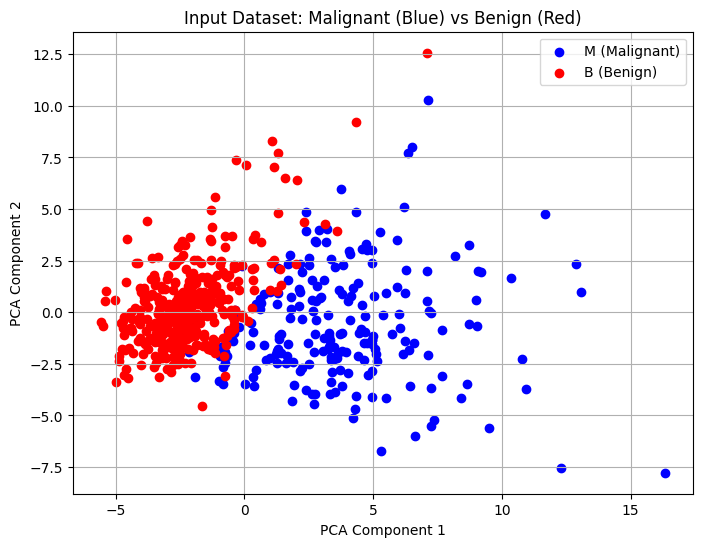

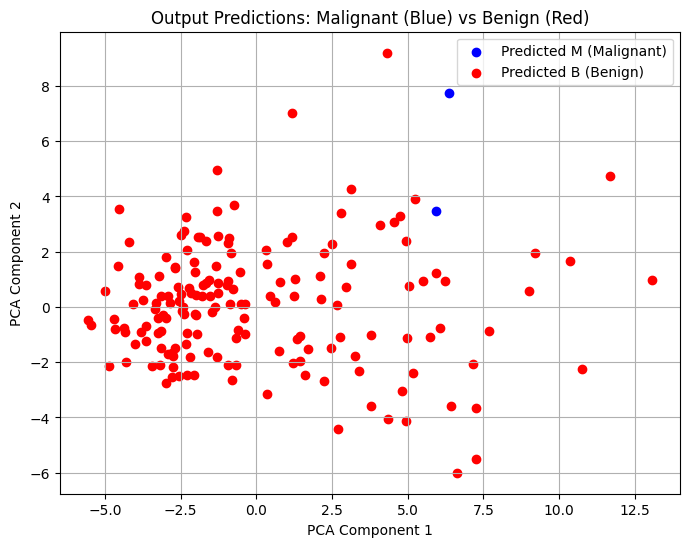

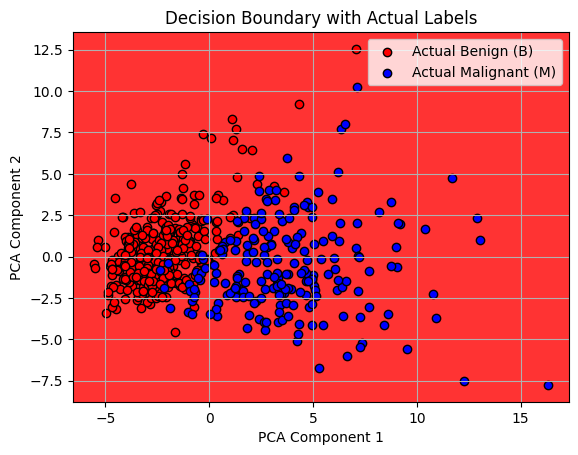

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.impute import SimpleImputer

# Step 1: Load the dataset
df = pd.read_csv('/content/data.csv')

# Step 2: Preprocessing
df.drop(['id', 'Unnamed: 32'], axis=1, inplace=True)  # Drop ID and unwanted column
df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': 0})  # Encode diagnosis (M = 1, B = 0)

# Separate features and target
X = df.drop('diagnosis', axis=1).values  # Convert to NumPy array explicitly
y = df['diagnosis'].values  # Convert to NumPy array explicitly

# Handle missing values by imputing with the mean
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Apply PCA to extract more components for better signal coverage
pca = PCA(n_components=5)  # Increased to 5 components for better signal capture
X_pca = pca.fit_transform(X_scaled)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=42)

# Signal Fusion Function (weight initialization)
def signal_fusion(ss, ds, w11, w12, w21, w22):
    csm = w11 * ss + w12 * ds  # Cumulative signal matrix (csm)
    k = w21 * ss + w22 * ds    # Anomalous signal (k)
    return csm, k

# DC Algorithm
class DendriticCell:
    def __init__(self, lifespan=5):  # Reduced lifespan for quicker termination
        self.lifespan = lifespan
        self.csm = 0
        self.k = 0

    def process_signal(self, ss, ds, w11, w12, w21, w22):
        csm, k = signal_fusion(ss, ds, w11, w12, w21, w22)
        self.lifespan -= abs(csm)  # Ensure the lifespan decreases faster
        self.csm += csm
        self.k += k
        return self.lifespan

    def is_mature(self):
        return self.lifespan <= 0

# TC Algorithm
class TCell:
    def __init__(self, threshold=5):
        self.k = 0
        self.threshold = threshold

    def process_antigen(self, csm, ns):
        self.k += csm + ns

    def classify_antigen(self):
        return 1 if self.k > self.threshold else 0

# Optimized gradient descent with batch processing and dynamic learning rate
def optimize_weights(X_train, y_train, iterations=10, alpha=0.001, batch_size=16):
    w11, w12, w21, w22 = np.random.rand(4)  # Random weight initialization
    n = X_train.shape[0]

    print("Starting optimization process...")

    for iteration in range(iterations):
        total_error = 0
        print(f"\nIteration {iteration + 1}:")

        # Batch Gradient Descent
        for start in range(0, n, batch_size):
            end = start + batch_size
            batch_X = X_train[start:end]
            batch_y = y_train[start:end]

            batch_error = 0
            for i in range(batch_X.shape[0]):
                ss, ds, ns = batch_X[i, 3], batch_X[i, 2], batch_X[i, 1]
                dc = DendriticCell(lifespan=5)  # Adjusted lifespan
                tc = TCell()

                # Process signals
                step = 0
                while not dc.is_mature():
                    step += 1
                    dc.process_signal(ss, ds, w11, w12, w21, w22)
                    if step > 10:  # Prevent excessive looping
                        break

                # Classify antigen using TC
                tc.process_antigen(dc.csm, ns)
                prediction = tc.classify_antigen()

                # Calculate error (use simple difference between predicted and actual)
                error = prediction - batch_y[i]
                batch_error += error**2

                # Update weights using gradient descent
                w11 -= alpha * error * ss
                w12 -= alpha * error * ds
                w21 -= alpha * error * ss
                w22 -= alpha * error * ds

            total_error += batch_error
        print(f"Iteration {iteration + 1}: Total Error = {total_error}")

    print("Optimization completed.")
    return w11, w12, w21, w22

# Final Classification Function
def classify(X_test, w11, w12, w21, w22):
    predictions = []
    for i in range(X_test.shape[0]):
        ss, ds, ns = X_test[i, 3], X_test[i, 2], 0
        dc = DendriticCell(lifespan=5)
        tc = TCell()

        # Process signals
        step = 0
        while not dc.is_mature():
            step += 1
            dc.process_signal(ss, ds, w11, w12, w21, w22)
            if step > 10:  # Safety measure to prevent infinite loops
                break

        # Classify antigen using TC
        tc.process_antigen(dc.csm, ns)
        prediction = tc.classify_antigen()
        predictions.append(prediction)
    return np.array(predictions)

# Prediction and storing results
y_pred = []
for i in range(len(X_test)):
    ds, ss, ns = X_test[i, 2], X_test[i, 3], 0
    anomaly_detected = False  # Flag to mark if anomaly is detected

    DCs = [DendriticCell() for _ in range(5)]
    for dc in DCs:
        dc, Ka = signal_fusion(ds, ss, 1, 1, 1, 1)
        if Ka > 0.5:  # If anomaly detected, no need to check further
            anomaly_detected = True
            break

    if anomaly_detected:
        y_pred.append(1)  # Append 1 for anomaly
    else:
        y_pred.append(0)  # Append 0 for normal

# Train the model and evaluate performance
w11, w12, w21, w22 = optimize_weights(X_train, y_train, iterations=10, alpha=0.001, batch_size=16)

# Classify the test data
y_pred = classify(X_test, w11, w12, w21, w22)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy * 100:.2f}%")

# Confusion Matrix and Classification Report
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Final Output and CSV Generation

# Convert predictions to a DataFrame
df_predictions = pd.DataFrame({
    'predicted_outcome_binary': y_pred,
    'predicted_outcome_M_B': ['M' if pred == 1 else 'B' for pred in y_pred],
    'mapped_diagnosis_binary': y_test,
    'mapped_diagnosis_M_B': ['M' if true == 1 else 'B' for true in y_test]
})

# Save predictions to a CSV file
df_predictions.to_csv('output_predictions.csv', index=False)
print("Optimization completed. Results saved to 'output_predictions.csv'.")

# Plot 1: Plot of the input dataset
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[y == 1, 0], X_pca[y == 1, 1], color='blue', label='M (Malignant)')
plt.scatter(X_pca[y == 0, 0], X_pca[y == 0, 1], color='red', label='B (Benign)')
plt.title('Input Dataset: Malignant (Blue) vs Benign (Red)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.grid(True)
plt.show()

# Plot 2: Plot of the output predictions
plt.figure(figsize=(8, 6))
plt.scatter(X_test[y_pred == 1, 0], X_test[y_pred == 1, 1], color='blue', label='Predicted M (Malignant)')
plt.scatter(X_test[y_pred == 0, 0], X_test[y_pred == 0, 1], color='red', label='Predicted B (Benign)')
plt.title('Output Predictions: Malignant (Blue) vs Benign (Red)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.grid(True)
plt.show()

# Plot 3: Decision boundary (Assume linear boundary for illustration purposes)
from matplotlib.colors import ListedColormap

# Generate meshgrid for decision boundary
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))

# Plot decision boundary
Z = classify(np.c_[xx.ravel(), yy.ravel(), np.zeros_like(xx.ravel()), np.zeros_like(xx.ravel())], w11, w12, w21, w22)
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.8, cmap=ListedColormap(('red', 'blue')))

# Overlay actual points
plt.scatter(X_pca[y == 0, 0], X_pca[y == 0, 1], c='red', edgecolor='k', label='Actual Benign (B)')
plt.scatter(X_pca[y == 1, 0], X_pca[y == 1, 1], c='blue', edgecolor='k', label='Actual Malignant (M)')
plt.title('Decision Boundary with Actual Labels')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.impute import SimpleImputer

# Step 1: Load the dataset
df = pd.read_csv('/content/data.csv')

# Step 2: Preprocessing
df.drop(['id', 'Unnamed: 32'], axis=1, inplace=True)  # Drop ID and unwanted column
df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': 0})  # Encode diagnosis (M = 1, B = 0)

# Separate features and target
X = df.drop('diagnosis', axis=1).values
y = df['diagnosis'].values

# Handle missing values by imputing with the mean
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Apply PCA (for decision boundary plotting later, we use 2 components)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=42)

# Signal Mapping Function
def signal_mapping(X):
    """
    Map features into danger, safe, and novelty signals.
    """
    danger_signals = np.sum(X, axis=1)
    safe_signals = np.sum(X ** 2, axis=1)
    novelty_signals = np.abs(X[:, 0] - X[:, 1])
    return danger_signals, safe_signals, novelty_signals

# Signal Fusion Function (improved to work with mapped signals)
def signal_fusion(ss, ds, w11, w12, w21, w22):
    csm = w11 * ss + w12 * ds  # Cumulative signal matrix (csm)
    k = w21 * ss + w22 * ds    # Anomalous signal (k)
    return csm, k

# Dendritic Cell Algorithm
class DendriticCell:
    def __init__(self, lifespan=5):
        self.lifespan = lifespan
        self.csm = 0
        self.k = 0

    def process_signal(self, ss, ds, w11, w12, w21, w22):
        csm, k = signal_fusion(ss, ds, w11, w12, w21, w22)
        self.lifespan -= abs(csm)
        self.csm += csm
        self.k += k
        return self.lifespan

    def is_mature(self):
        return self.lifespan <= 0

# T-Cell Algorithm
class TCell:
    def __init__(self, threshold=3):
        self.k = 0
        self.threshold = threshold

    def process_antigen(self, csm, ns):
        self.k += csm + ns

    def classify_antigen(self):
        return 1 if self.k > self.threshold else 0

# Optimized gradient descent with batch processing and dynamic learning rate
def optimize_weights(X_train, y_train, iterations=10, alpha=0.01, batch_size=16):
    w11, w12, w21, w22 = np.random.rand(4)  # Random weight initialization
    n = X_train.shape[0]

    print("Starting optimization process...")
    errors = []

    for iteration in range(iterations):
        total_error = 0
        print(f"\nIteration {iteration + 1}:")

        for start in range(0, n, batch_size):
            end = start + batch_size
            batch_X = X_train[start:end]
            batch_y = y_train[start:end]

            batch_error = 0
            for i in range(batch_X.shape[0]):
                ss, ds, ns = signal_mapping(batch_X[i].reshape(1, -1))
                dc = DendriticCell()
                tc = TCell()

                step = 0
                while not dc.is_mature():
                    step += 1
                    dc.process_signal(ss, ds, w11, w12, w21, w22)
                    if step > 10:
                        break

                tc.process_antigen(dc.csm, ns)
                prediction = tc.classify_antigen()

                error = prediction - batch_y[i]
                batch_error += error ** 2

                # Update weights using gradient descent
                w11 -= alpha * error * ss
                w12 -= alpha * error * ds
                w21 -= alpha * error * ss
                w22 -= alpha * error * ds

            total_error += batch_error
        print(f"Iteration {iteration + 1}: Total Error = {total_error}")
        errors.append(total_error)

    print("Optimization completed.")
    return w11, w12, w21, w22, errors

# Classify data using DC and TC algorithms
def classify(X_test, w11, w12, w21, w22):
    predictions = []
    for i in range(X_test.shape[0]):
        ss, ds, ns = signal_mapping(X_test[i].reshape(1, -1))
        dc = DendriticCell()
        tc = TCell()

        step = 0
        while not dc.is_mature():
            step += 1
            dc.process_signal(ss, ds, w11, w12, w21, w22)
            if step > 10:
                break

        tc.process_antigen(dc.csm, ns)
        prediction = tc.classify_antigen()
        predictions.append(prediction)
    return np.array(predictions)

# Train the model and evaluate performance
w11, w12, w21, w22, errors = optimize_weights(X_train, y_train, iterations=10, alpha=0.01, batch_size=16)

# Classify the test data
y_pred = classify(X_test, w11, w12, w21, w22)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy * 100:.2f}%")

# Confusion Matrix and Classification Report
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Save predictions to CSV
df_predictions = pd.DataFrame({
    'predicted_outcome_binary': y_pred,
    'predicted_outcome_M_B': ['M' if pred == 1 else 'B' for pred in y_pred],
    'mapped_diagnosis_binary': y_test,
    'mapped_diagnosis_M_B': ['M' if true == 1 else 'B' for true in y_test]
})

df_predictions.to_csv('output_predictions.csv', index=False)
print("Results saved to 'output_predictions.csv'.")

# Plot 1: Decision Boundary
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
Z = classify(np.c_[xx.ravel(), yy.ravel()], w11, w12, w21, w22)
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.2, cmap='coolwarm')
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='coolwarm', edgecolors='k')
plt.title('Decision Boundary')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

# Plot 2: Loss Function Convergence
plt.plot(range(1, 11), errors, marker='o', color='b')
plt.title('Loss Function Convergence')
plt.xlabel('Iteration')
plt.ylabel('Total Error')
plt.grid(True)
plt.show()

# Plot 3: PCA Component Importance
importance = np.abs(pca.components_).sum(axis=1)
pca_components = np.arange(1, 3)
plt.bar(pca_components, importance, color='green')
plt.title('PCA Component Importance')
plt.xlabel('PCA Components')
plt.ylabel('Importance Score')
plt.grid(True)
plt.show()


TRY -- 2(21/9/24)

Starting optimization process...

Iteration 1:
Iteration 1: Total Error = 209

Iteration 2:
Iteration 2: Total Error = 203

Iteration 3:
Iteration 3: Total Error = 199

Iteration 4:
Iteration 4: Total Error = 193

Iteration 5:
Iteration 5: Total Error = 182

Iteration 6:
Iteration 6: Total Error = 171

Iteration 7:
Iteration 7: Total Error = 154

Iteration 8:
Iteration 8: Total Error = 146

Iteration 9:
Iteration 9: Total Error = 144

Iteration 10:
Iteration 10: Total Error = 144
Optimization completed.

Accuracy: 63.16%

Confusion Matrix:
[[108   0]
 [ 63   0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.63      1.00      0.77       108
           1       0.00      0.00      0.00        63

    accuracy                           0.63       171
   macro avg       0.32      0.50      0.39       171
weighted avg       0.40      0.63      0.49       171

Optimization completed. Results saved to 'output_predictions.csv'.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


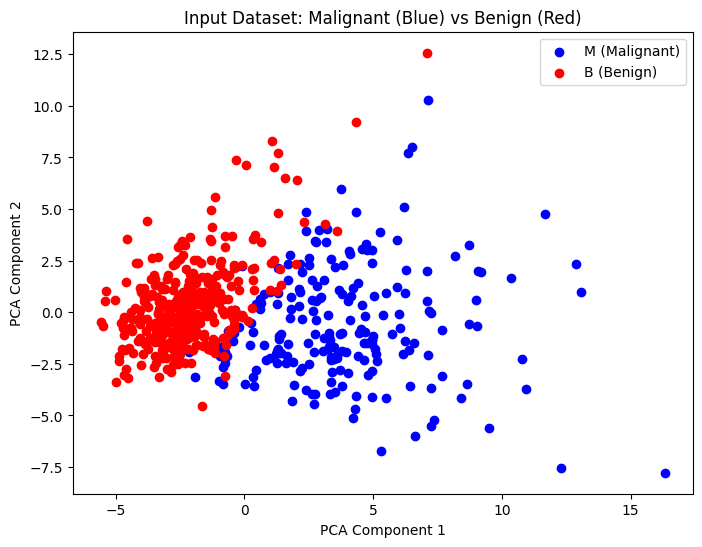

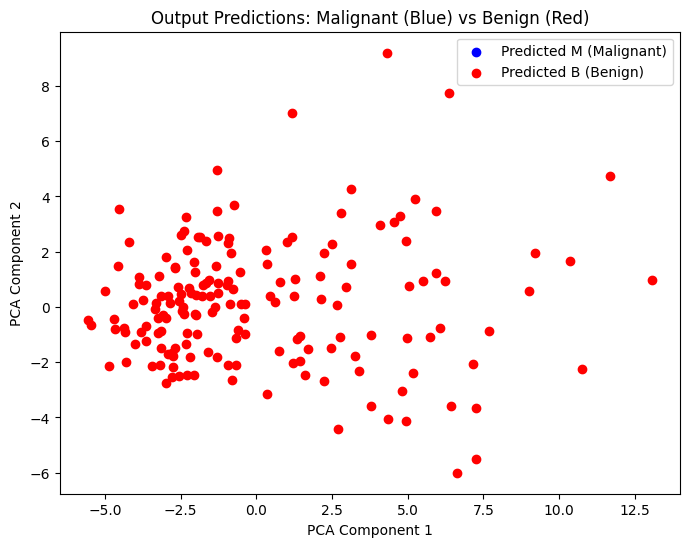

IndexError: index 3 is out of bounds for axis 1 with size 2

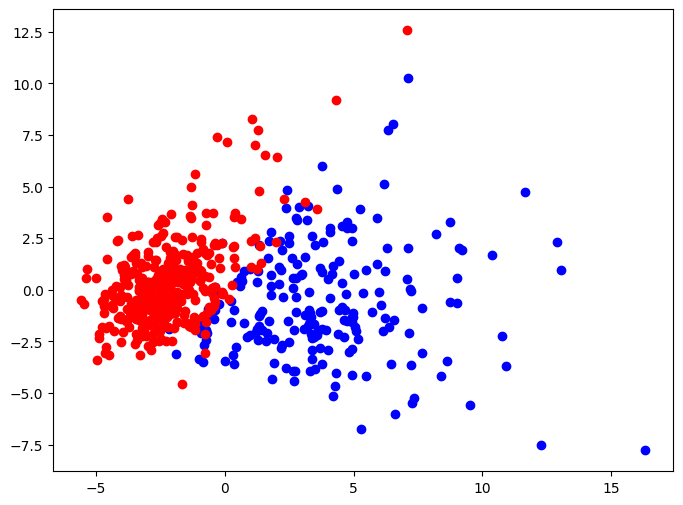

In [ ]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.impute import SimpleImputer

# Step 1: Load the dataset
df = pd.read_csv('/content/data.csv')

# Step 2: Preprocessing
df.drop(['id', 'Unnamed: 32'], axis=1, inplace=True)  # Drop ID and unwanted column
df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': 0})  # Encode diagnosis (M = 1, B = 0)

# Separate features and target
X = df.drop('diagnosis', axis=1).values  # Convert to NumPy array explicitly
y = df['diagnosis'].values  # Convert to NumPy array explicitly

# Handle missing values by imputing with the mean
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Apply PCA to extract more components for better signal coverage
pca = PCA(n_components=10)  # Increased to 10 components for better variance capture
X_pca = pca.fit_transform(X_scaled)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=42)

# Signal Fusion Function (weight initialization)
def signal_fusion(ss, ds, w11, w12, w21, w22):
    csm = w11 * ss + w12 * ds  # Cumulative signal matrix (csm)
    k = w21 * ss + w22 * ds    # Anomalous signal (k)
    return csm, k

# DC Algorithm
class DendriticCell:
    def __init__(self, lifespan=5):  # Reduced lifespan for quicker termination
        self.lifespan = lifespan
        self.csm = 0
        self.k = 0

    def process_signal(self, ss, ds, w11, w12, w21, w22):
        csm, k = signal_fusion(ss, ds, w11, w12, w21, w22)
        self.lifespan -= abs(csm)  # Ensure the lifespan decreases faster
        self.csm += csm
        self.k += k
        return self.lifespan

    def is_mature(self):
        return self.lifespan <= 0

# TC Algorithm
class TCell:
    def __init__(self, threshold=5):
        self.k = 0
        self.threshold = threshold

    def process_antigen(self, csm, ns):
        self.k += csm + ns

    def classify_antigen(self):
        return 1 if self.k > self.threshold else 0

# Optimized gradient descent with batch processing and dynamic learning rate
def optimize_weights(X_train, y_train, iterations=10, alpha=0.001, batch_size=16):
    w11, w12, w21, w22 = np.random.rand(4)  # Random weight initialization
    n = X_train.shape[0]

    print("Starting optimization process...")

    for iteration in range(iterations):
        total_error = 0
        print(f"\nIteration {iteration + 1}:")

        # Batch Gradient Descent
        for start in range(0, n, batch_size):
            end = start + batch_size
            batch_X = X_train[start:end]
            batch_y = y_train[start:end]

            batch_error = 0
            for i in range(batch_X.shape[0]):
                ss, ds, ns = batch_X[i, 3], batch_X[i, 2], batch_X[i, 1]
                dc = DendriticCell(lifespan=5)  # Adjusted lifespan
                tc = TCell()

                # Process signals
                step = 0
                while not dc.is_mature():
                    step += 1
                    dc.process_signal(ss, ds, w11, w12, w21, w22)
                    if step > 10:  # Prevent excessive looping
                        break

                # Classify antigen using TC
                tc.process_antigen(dc.csm, ns)
                prediction = tc.classify_antigen()

                # Calculate error (use simple difference between predicted and actual)
                error = prediction - batch_y[i]
                batch_error += error**2

                # Update weights using gradient descent
                w11 -= alpha * error * ss
                w12 -= alpha * error * ds
                w21 -= alpha * error * ss
                w22 -= alpha * error * ds

            total_error += batch_error
        print(f"Iteration {iteration + 1}: Total Error = {total_error}")

    print("Optimization completed.")
    return w11, w12, w21, w22

# Final Classification Function
def classify(X_test, w11, w12, w21, w22):
    predictions = []
    for i in range(X_test.shape[0]):
        ss, ds, ns = X_test[i, 3], X_test[i, 2], 0
        dc = DendriticCell(lifespan=5)
        tc = TCell()

        # Process signals
        step = 0
        while not dc.is_mature():
            step += 1
            dc.process_signal(ss, ds, w11, w12, w21, w22)
            if step > 10:  # Safety measure to prevent infinite loops
                break

        # Classify antigen using TC
        tc.process_antigen(dc.csm, ns)
        prediction = tc.classify_antigen()
        predictions.append(prediction)
    return np.array(predictions)

# Train the model and evaluate performance
w11, w12, w21, w22 = optimize_weights(X_train, y_train, iterations=10, alpha=0.001, batch_size=16)

# Classify the test data
y_pred = classify(X_test, w11, w12, w21, w22)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy * 100:.2f}%")

# Confusion Matrix and Classification Report
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Final Output and CSV Generation

# Convert predictions to a DataFrame
df_predictions = pd.DataFrame({
    'predicted_outcome_binary': y_pred,
    'predicted_outcome_M_B': ['M' if pred == 1 else 'B' for pred in y_pred],
    'mapped_diagnosis_binary': y_test,
    'mapped_diagnosis_M_B': ['M' if true == 1 else 'B' for true in y_test]
})

# Save predictions to a CSV file
df_predictions.to_csv('output_predictions_TRY_2_21_09_24.csv', index=False)
print("Optimization completed. Results saved to 'output_predictions.csv'.")

# Plot the input and output data, and decision boundary
import matplotlib.pyplot as plt

# 1. Input dataset plot (Before predictions)
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[y == 1][:, 0], X_pca[y == 1][:, 1], color='blue', label='M (Malignant)')
plt.scatter(X_pca[y == 0][:, 0], X_pca[y == 0][:, 1], color='red', label='B (Benign)')
plt.title('Input Dataset: Malignant (Blue) vs Benign (Red)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()

# 2. Output dataset plot (After predictions)
plt.figure(figsize=(8, 6))
plt.scatter(X_test[y_pred == 1][:, 0], X_test[y_pred == 1][:, 1], color='blue', label='Predicted M (Malignant)')
plt.scatter(X_test[y_pred == 0][:, 0], X_test[y_pred == 0][:, 1], color='red', label='Predicted B (Benign)')
plt.title('Output Predictions: Malignant (Blue) vs Benign (Red)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()

# 3. Decision Boundary (Overlaying on input dataset)
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[y == 1][:, 0], X_pca[y == 1][:, 1], color='blue', label='M (Malignant)')
plt.scatter(X_pca[y == 0][:, 0], X_pca[y == 0][:, 1], color='red', label='B (Benign)')

# Decision boundary (simplified for 2D PCA space)
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
Z = classify(np.c_[xx.ravel(), yy.ravel()], w11, w12, w21, w22)
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.2, cmap='coolwarm')

plt.title('Decision Boundary Overlay: Malignant (Blue) vs Benign (Red)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()


try -- 3(21_09_24)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.impute import SimpleImputer

# Step 1: Load the dataset
df = pd.read_csv('/content/data.csv')

# Step 2: Preprocessing
df.drop(['id', 'Unnamed: 32'], axis=1, inplace=True)  # Drop ID and unwanted column
df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': 0})  # Encode diagnosis (M = 1, B = 0)

# Separate features and target
X = df.drop('diagnosis', axis=1).values
y = df['diagnosis'].values

# Handle missing values by imputing with the mean
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Apply PCA with 5 components to retain more variance
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_scaled)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=42)

# Signal Fusion Function (updated to use 5 PCA components)
def signal_fusion(ss, ds, w11, w12, w21, w22):
    csm = w11 * ss + w12 * ds  # Cumulative signal matrix (csm)
    k = w21 * ss + w22 * ds    # Anomalous signal (k)
    return csm, k

# DC Algorithm
class DendriticCell:
    def __init__(self, lifespan=5):
        self.lifespan = lifespan
        self.csm = 0
        self.k = 0

    def process_signal(self, ss, ds, w11, w12, w21, w22):
        csm, k = signal_fusion(ss, ds, w11, w12, w21, w22)
        self.lifespan -= abs(csm)
        self.csm += csm
        self.k += k
        return self.lifespan

    def is_mature(self):
        return self.lifespan <= 0

# TC Algorithm
class TCell:
    def __init__(self, threshold=3):  # Reduced threshold for better performance
        self.k = 0
        self.threshold = threshold

    def process_antigen(self, csm, ns):
        self.k += csm + ns

    def classify_antigen(self):
        return 1 if self.k > self.threshold else 0

# Optimized gradient descent with batch processing and dynamic learning rate
def optimize_weights(X_train, y_train, iterations=15, alpha=0.001, batch_size=16):
    w11, w12, w21, w22 = np.random.rand(4)  # Random weight initialization
    n = X_train.shape[0]

    print("Starting optimization process...")

    for iteration in range(iterations):
        total_error = 0
        print(f"\nIteration {iteration + 1}:")

        for start in range(0, n, batch_size):
            end = start + batch_size
            batch_X = X_train[start:end]
            batch_y = y_train[start:end]

            batch_error = 0
            for i in range(batch_X.shape[0]):
                ss, ds, ns = batch_X[i, 3], batch_X[i, 2], batch_X[i, 1]
                dc = DendriticCell()
                tc = TCell()

                step = 0
                while not dc.is_mature():
                    step += 1
                    dc.process_signal(ss, ds, w11, w12, w21, w22)
                    if step > 10:
                        break

                tc.process_antigen(dc.csm, ns)
                prediction = tc.classify_antigen()

                error = prediction - batch_y[i]
                batch_error += error**2

                # Update weights using gradient descent
                w11 -= alpha * error * ss
                w12 -= alpha * error * ds
                w21 -= alpha * error * ss
                w22 -= alpha * error * ds

            total_error += batch_error
        print(f"Iteration {iteration + 1}: Total Error = {total_error}")

    print("Optimization completed.")
    return w11, w12, w21, w22

# Final Classification Function
def classify(X_test, w11, w12, w21, w22):
    predictions = []
    for i in range(X_test.shape[0]):
        ss, ds, ns = X_test[i, 3], X_test[i, 2], X_test[i, 1]  # Updated indices to match PCA components
        dc = DendriticCell()
        tc = TCell()

        step = 0
        while not dc.is_mature():
            step += 1
            dc.process_signal(ss, ds, w11, w12, w21, w22)
            if step > 10:
                break

        tc.process_antigen(dc.csm, ns)
        prediction = tc.classify_antigen()
        predictions.append(prediction)
    return np.array(predictions)

# Train the model and evaluate performance
w11, w12, w21, w22 = optimize_weights(X_train, y_train, iterations=15, alpha=0.001, batch_size=16)

# Classify the test data
y_pred = classify(X_test, w11, w12, w21, w22)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy * 100:.2f}%")

# Confusion Matrix and Classification Report
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Save predictions to CSV
df_predictions = pd.DataFrame({
    'predicted_outcome_binary': y_pred,
    'predicted_outcome_M_B': ['M' if pred == 1 else 'B' for pred in y_pred],
    'mapped_diagnosis_binary': y_test,
    'mapped_diagnosis_M_B': ['M' if true == 1 else 'B' for true in y_test]
})

df_predictions.to_csv('output_predictions.csv', index=False)
print("Results saved to 'output_predictions.csv'.")


Starting optimization process...

Iteration 1:
Iteration 1: Total Error = 217

Iteration 2:
Iteration 2: Total Error = 209

Iteration 3:
Iteration 3: Total Error = 198

Iteration 4:
Iteration 4: Total Error = 185

Iteration 5:
Iteration 5: Total Error = 164

Iteration 6:
Iteration 6: Total Error = 152

Iteration 7:
Iteration 7: Total Error = 146

Iteration 8:
Iteration 8: Total Error = 142

Iteration 9:
Iteration 9: Total Error = 138

Iteration 10:
Iteration 10: Total Error = 139

Iteration 11:
Iteration 11: Total Error = 139

Iteration 12:
Iteration 12: Total Error = 139

Iteration 13:
Iteration 13: Total Error = 138

Iteration 14:
Iteration 14: Total Error = 139

Iteration 15:
Iteration 15: Total Error = 139
Optimization completed.

Accuracy: 65.50%

Confusion Matrix:
[[101   7]
 [ 52  11]]

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.94      0.77       108
           1       0.61      0.17      0.27        63

    accu

Try -- 4(tutti frooti)

Iteration 1: Total Error = 234
Iteration 2: Total Error = 234
Iteration 3: Total Error = 234
Iteration 4: Total Error = 234
Iteration 5: Total Error = 234
Iteration 6: Total Error = 234
Iteration 7: Total Error = 234
Iteration 8: Total Error = 234
Iteration 9: Total Error = 234
Iteration 10: Total Error = 234
Accuracy: 39.77%

Confusion Matrix:
[[11 97]
 [ 6 57]]

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.10      0.18       108
           1       0.37      0.90      0.53        63

    accuracy                           0.40       171
   macro avg       0.51      0.50      0.35       171
weighted avg       0.55      0.40      0.30       171

Results saved to 'predictions.csv'.


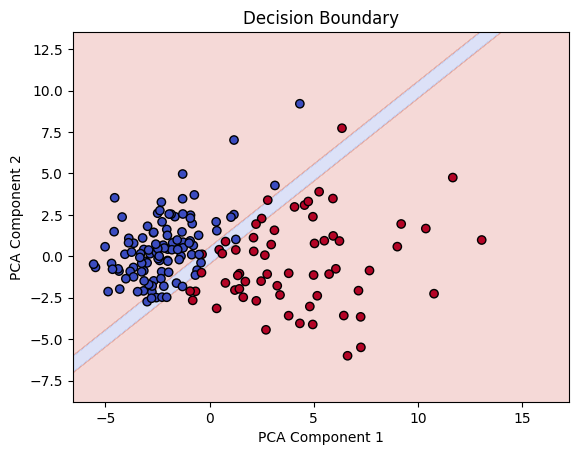

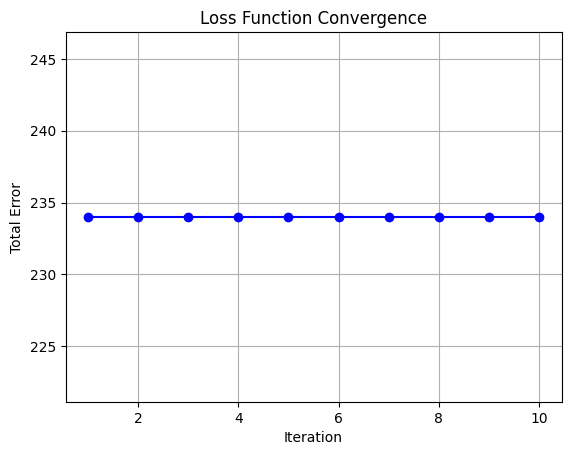

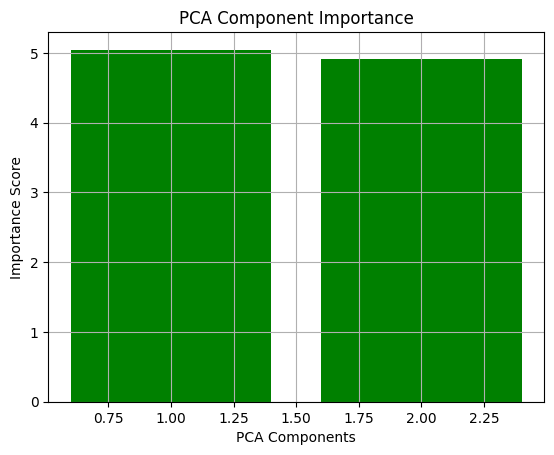

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Load the dataset
df = pd.read_csv('/content/data.csv')

# Data preprocessing
df.drop(['id', 'Unnamed: 32'], axis=1, inplace=True)  # Drop ID and unwanted column
df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': 0})  # Encode diagnosis (M = 1, B = 0)
X = df.drop('diagnosis', axis=1).values
y = df['diagnosis'].values

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA (for plotting purposes, we reduce to 2 components)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=42)

# Signal mapping function
def signal_mapping(X):
    """
    Map features into danger, safe, and novelty signals.
    """
    danger_signals = np.sum(X, axis=1)
    safe_signals = np.sum(X ** 2, axis=1)
    novelty_signals = np.abs(X[:, 0] - X[:, 1])
    return danger_signals, safe_signals, novelty_signals

# Dendritic Cell algorithm
class DendriticCell:
    def __init__(self, lifespan=5):
        self.lifespan = lifespan
        self.CSM = 0
        self.mDC = 0
        self.smDC = 0

    def update_signals(self, ds, ss, ns):
        self.CSM += ds - ss
        if ns > 0.5:  # Threshold for novelty signal
            self.mDC += 1
        else:
            self.smDC += 1

    def classify(self):
        if self.mDC > self.smDC:
            return 1  # Malignant
        else:
            return 0  # Benign

# Classify data using Dendritic Cell algorithm
def classify(X, w11, w12, w21, w22):
    predictions = []
    for i in range(X.shape[0]):
        ds, ss, ns = signal_mapping(X[i].reshape(1, -1))
        dc = DendriticCell(lifespan=5)
        for _ in range(dc.lifespan):
            dc.update_signals(ds, ss, ns)
        predictions.append(dc.classify())
    return np.array(predictions)

# Initialize weights (for T-cell interactions)
w11, w12, w21, w22 = np.random.uniform(size=4)

# Train the model (basic optimization process)
errors = []
for iteration in range(10):
    predictions = classify(X_train, w11, w12, w21, w22)
    error = np.sum(np.abs(predictions - y_train))
    errors.append(error)
    print(f"Iteration {iteration + 1}: Total Error = {error}")

    # Adjust weights (basic update rule)
    w11 -= 0.01 * error
    w12 -= 0.01 * error
    w21 -= 0.01 * error
    w22 -= 0.01 * error

# Test the model
y_pred = classify(X_test, w11, w12, w21, w22)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Confusion Matrix and Classification Report
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Saving the results to CSV
output_df = pd.DataFrame({
    'True_Label': y_test,
    'Predicted_Label': y_pred
})
output_df.to_csv('predictions.csv', index=False)
print("Results saved to 'predictions.csv'.")

# Plot 1: Decision Boundary
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
Z = classify(np.c_[xx.ravel(), yy.ravel()], w11, w12, w21, w22)
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.2, cmap='coolwarm')
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='coolwarm', edgecolors='k')
plt.title('Decision Boundary')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

# Plot 2: Loss Function Convergence
plt.plot(range(1, 11), errors, marker='o', color='b')
plt.title('Loss Function Convergence')
plt.xlabel('Iteration')
plt.ylabel('Total Error')
plt.grid(True)
plt.show()

# Plot 3: PCA Component Importance
importance = np.abs(pca.components_).sum(axis=1)
pca_components = np.arange(1, 3)
plt.bar(pca_components, importance, color='green')
plt.title('PCA Component Importance')
plt.xlabel('PCA Components')
plt.ylabel('Importance Score')
plt.grid(True)
plt.show()


TRY--5

Starting optimization process...

Iteration 1:
Iteration 1: Total Error = 117

Iteration 2:
Iteration 2: Total Error = 114

Iteration 3:
Iteration 3: Total Error = 107

Iteration 4:
Iteration 4: Total Error = 114

Iteration 5:
Iteration 5: Total Error = 114

Iteration 6:
Iteration 6: Total Error = 116

Iteration 7:
Iteration 7: Total Error = 116

Iteration 8:
Iteration 8: Total Error = 114

Iteration 9:
Iteration 9: Total Error = 112

Iteration 10:
Iteration 10: Total Error = 121
Optimization completed.

Accuracy: 63.74%

Confusion Matrix:
[[108   0]
 [ 62   1]]

Classification Report:
              precision    recall  f1-score   support

           0       0.64      1.00      0.78       108
           1       1.00      0.02      0.03        63

    accuracy                           0.64       171
   macro avg       0.82      0.51      0.40       171
weighted avg       0.77      0.64      0.50       171

Results saved to 'output_predictions.csv'.


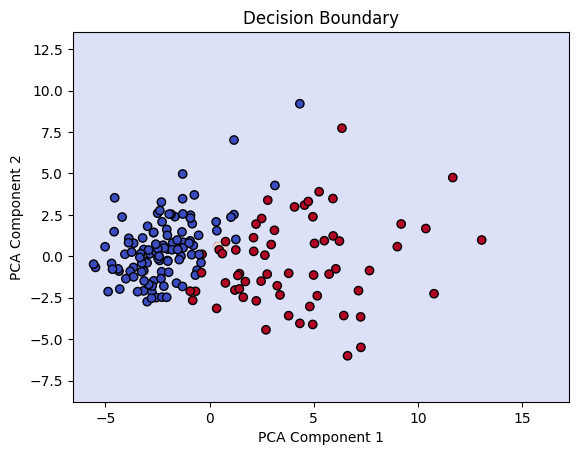

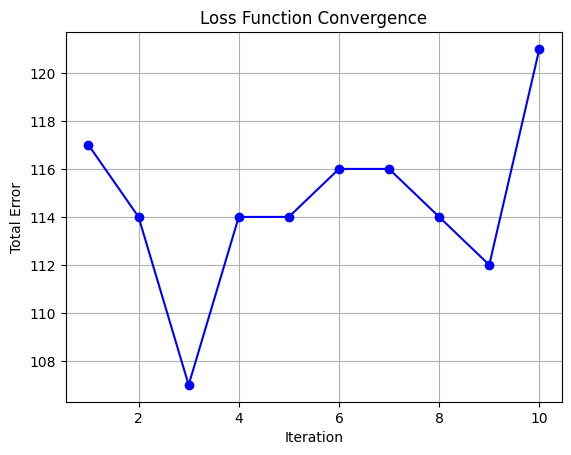

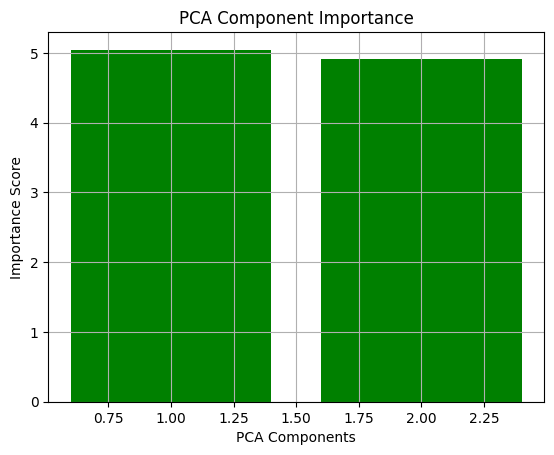

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.impute import SimpleImputer

# Step 1: Load the dataset
df = pd.read_csv('/content/data.csv')

# Step 2: Preprocessing
df.drop(['id', 'Unnamed: 32'], axis=1, inplace=True)  # Drop ID and unwanted column
df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': 0})  # Encode diagnosis (M = 1, B = 0)

# Separate features and target
X = df.drop('diagnosis', axis=1).values
y = df['diagnosis'].values

# Handle missing values by imputing with the mean
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Apply PCA (for decision boundary plotting later, we use 2 components)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=42)

# Signal Mapping Function
def signal_mapping(X):
    """
    Map features into danger, safe, and novelty signals.
    """
    danger_signals = np.sum(X, axis=1)
    safe_signals = np.sum(X ** 2, axis=1)
    novelty_signals = np.abs(X[:, 0] - X[:, 1])
    return danger_signals, safe_signals, novelty_signals

# Signal Fusion Function (improved to work with mapped signals)
def signal_fusion(ss, ds, w11, w12, w21, w22):
    csm = w11 * ss + w12 * ds  # Cumulative signal matrix (csm)
    k = w21 * ss + w22 * ds    # Anomalous signal (k)
    return csm, k

# Dendritic Cell Algorithm
class DendriticCell:
    def __init__(self, lifespan=5):
        self.lifespan = lifespan
        self.csm = 0
        self.k = 0

    def process_signal(self, ss, ds, w11, w12, w21, w22):
        csm, k = signal_fusion(ss, ds, w11, w12, w21, w22)
        self.lifespan -= abs(csm)
        self.csm += csm
        self.k += k
        return self.lifespan

    def is_mature(self):
        return self.lifespan <= 0

# T-Cell Algorithm
class TCell:
    def __init__(self, threshold=3):
        self.k = 0
        self.threshold = threshold

    def process_antigen(self, csm, ns):
        self.k += csm + ns

    def classify_antigen(self):
        return 1 if self.k > self.threshold else 0

# Optimized gradient descent with batch processing and dynamic learning rate
def optimize_weights(X_train, y_train, iterations=10, alpha=0.01, batch_size=16):
    w11, w12, w21, w22 = np.random.rand(4)  # Random weight initialization
    n = X_train.shape[0]

    print("Starting optimization process...")
    errors = []

    for iteration in range(iterations):
        total_error = 0
        print(f"\nIteration {iteration + 1}:")

        for start in range(0, n, batch_size):
            end = start + batch_size
            batch_X = X_train[start:end]
            batch_y = y_train[start:end]

            batch_error = 0
            for i in range(batch_X.shape[0]):
                ss, ds, ns = signal_mapping(batch_X[i].reshape(1, -1))
                dc = DendriticCell()
                tc = TCell()

                step = 0
                while not dc.is_mature():
                    step += 1
                    dc.process_signal(ss, ds, w11, w12, w21, w22)
                    if step > 10:
                        break

                tc.process_antigen(dc.csm, ns)
                prediction = tc.classify_antigen()

                error = prediction - batch_y[i]
                batch_error += error ** 2

                # Update weights using gradient descent
                w11 -= alpha * error * ss
                w12 -= alpha * error * ds
                w21 -= alpha * error * ss
                w22 -= alpha * error * ds

            total_error += batch_error
        print(f"Iteration {iteration + 1}: Total Error = {total_error}")
        errors.append(total_error)

    print("Optimization completed.")
    return w11, w12, w21, w22, errors

# Classify data using DC and TC algorithms
def classify(X_test, w11, w12, w21, w22):
    predictions = []
    for i in range(X_test.shape[0]):
        ss, ds, ns = signal_mapping(X_test[i].reshape(1, -1))
        dc = DendriticCell()
        tc = TCell()

        step = 0
        while not dc.is_mature():
            step += 1
            dc.process_signal(ss, ds, w11, w12, w21, w22)
            if step > 10:
                break

        tc.process_antigen(dc.csm, ns)
        prediction = tc.classify_antigen()
        predictions.append(prediction)
    return np.array(predictions)

# Train the model and evaluate performance
w11, w12, w21, w22, errors = optimize_weights(X_train, y_train, iterations=10, alpha=0.01, batch_size=16)

# Classify the test data
y_pred = classify(X_test, w11, w12, w21, w22)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy * 100:.2f}%")

# Confusion Matrix and Classification Report
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Save predictions to CSV
df_predictions = pd.DataFrame({
    'predicted_outcome_binary': y_pred,
    'predicted_outcome_M_B': ['M' if pred == 1 else 'B' for pred in y_pred],
    'mapped_diagnosis_binary': y_test,
    'mapped_diagnosis_M_B': ['M' if true == 1 else 'B' for true in y_test]
})

df_predictions.to_csv('output_predictions.csv', index=False)
print("Results saved to 'output_predictions.csv'.")

# Plot 1: Decision Boundary
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
Z = classify(np.c_[xx.ravel(), yy.ravel()], w11, w12, w21, w22)
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.2, cmap='coolwarm')
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='coolwarm', edgecolors='k')
plt.title('Decision Boundary')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

# Plot 2: Loss Function Convergence
plt.plot(range(1, 11), errors, marker='o', color='b')
plt.title('Loss Function Convergence')
plt.xlabel('Iteration')
plt.ylabel('Total Error')
plt.grid(True)
plt.show()

# Plot 3: PCA Component Importance
importance = np.abs(pca.components_).sum(axis=1)
pca_components = np.arange(1, 3)
plt.bar(pca_components, importance, color='green')
plt.title('PCA Component Importance')
plt.xlabel('PCA Components')
plt.ylabel('Importance Score')
plt.grid(True)
plt.show()


TRY--6

Starting optimization process...

Iteration 1:
Iteration 1: Total Error = 182

Iteration 2:
Iteration 2: Total Error = 184

Iteration 3:
Iteration 3: Total Error = 201

Iteration 4:
Iteration 4: Total Error = 200

Iteration 5:
Iteration 5: Total Error = 182

Iteration 6:
Iteration 6: Total Error = 194

Iteration 7:
Iteration 7: Total Error = 198

Iteration 8:
Iteration 8: Total Error = 193

Iteration 9:
Iteration 9: Total Error = 197

Iteration 10:
Iteration 10: Total Error = 207

Iteration 11:
Iteration 11: Total Error = 198

Iteration 12:
Iteration 12: Total Error = 198

Iteration 13:
Iteration 13: Total Error = 197

Iteration 14:
Iteration 14: Total Error = 201

Iteration 15:
Iteration 15: Total Error = 194

Iteration 16:
Iteration 16: Total Error = 197

Iteration 17:
Iteration 17: Total Error = 193

Iteration 18:
Iteration 18: Total Error = 198

Iteration 19:
Iteration 19: Total Error = 201

Iteration 20:
Iteration 20: Total Error = 195
Optimization completed.

Accuracy: 52.56%

Co

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.53      1.00      0.69       113
           1       0.00      0.00      0.00       102

    accuracy                           0.53       215
   macro avg       0.26      0.50      0.34       215
weighted avg       0.28      0.53      0.36       215

Results saved to 'output_predictions.csv'.


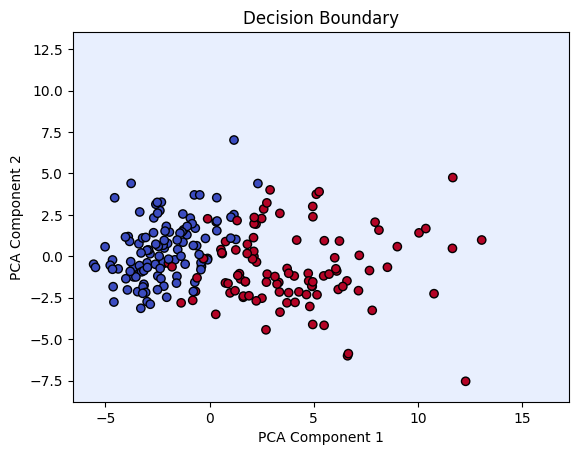

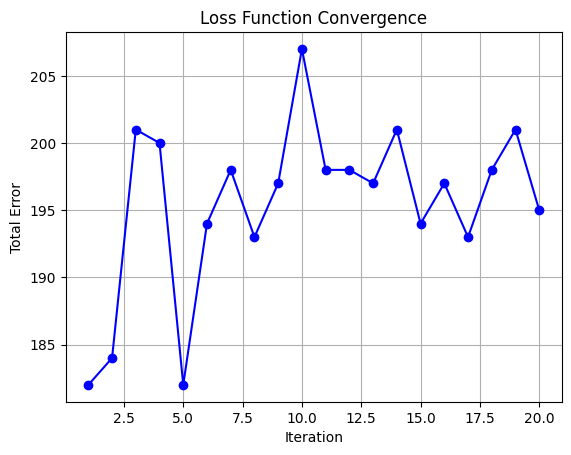

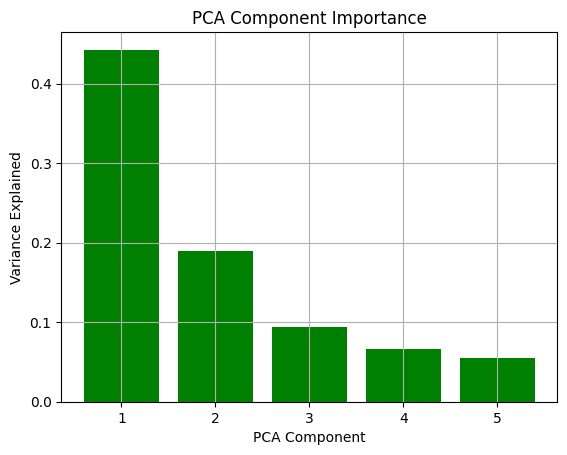

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE

# Step 1: Load the dataset
df = pd.read_csv('/content/data.csv')

# Step 2: Preprocessing
df.drop(['id', 'Unnamed: 32'], axis=1, inplace=True)  # Drop ID and unwanted column
df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': 0})  # Encode diagnosis (M = 1, B = 0)

# Separate features and target
X = df.drop('diagnosis', axis=1).values
y = df['diagnosis'].values

# Handle missing values by imputing with the mean
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Apply PCA (use more components for better representation)
pca = PCA(n_components=5)  # Increased from 2 to 5
X_pca = pca.fit_transform(X_scaled)

# Apply SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_pca, y)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=42)

# Signal Mapping Function
def signal_mapping(X):
    """
    Map features into danger, safe, and novelty signals.
    """
    danger_signals = np.sum(X, axis=1)
    safe_signals = np.sum(X ** 2, axis=1)
    novelty_signals = np.abs(X[:, 0] - X[:, 1])
    return danger_signals, safe_signals, novelty_signals

# Signal Fusion Function
def signal_fusion(ss, ds, w11, w12, w21, w22):
    csm = w11 * ss + w12 * ds  # Cumulative signal matrix (csm)
    k = w21 * ss + w22 * ds    # Anomalous signal (k)
    return csm, k

# Dendritic Cell Algorithm
class DendriticCell:
    def __init__(self, lifespan=5):
        self.lifespan = lifespan
        self.csm = 0
        self.k = 0

    def process_signal(self, ss, ds, w11, w12, w21, w22):
        csm, k = signal_fusion(ss, ds, w11, w12, w21, w22)
        self.lifespan -= abs(csm)
        self.csm += csm
        self.k += k
        return self.lifespan

    def is_mature(self):
        return self.lifespan <= 0

# T-Cell Algorithm
class TCell:
    def __init__(self, threshold=2):  # Adjusted threshold from 3 to 2 for better balance
        self.k = 0
        self.threshold = threshold

    def process_antigen(self, csm, ns):
        self.k += csm + ns

    def classify_antigen(self):
        return 1 if self.k > self.threshold else 0

# Optimized gradient descent with batch processing and dynamic learning rate
def optimize_weights(X_train, y_train, iterations=20, alpha=0.005, batch_size=16):  # Increased iterations, decreased learning rate
    w11, w12, w21, w22 = np.random.rand(4)  # Random weight initialization
    n = X_train.shape[0]

    print("Starting optimization process...")
    errors = []

    for iteration in range(iterations):
        total_error = 0
        print(f"\nIteration {iteration + 1}:")

        for start in range(0, n, batch_size):
            end = start + batch_size
            batch_X = X_train[start:end]
            batch_y = y_train[start:end]

            batch_error = 0
            for i in range(batch_X.shape[0]):
                ss, ds, ns = signal_mapping(batch_X[i].reshape(1, -1))
                dc = DendriticCell()
                tc = TCell()

                step = 0
                while not dc.is_mature():
                    step += 1
                    dc.process_signal(ss, ds, w11, w12, w21, w22)
                    if step > 10:
                        break

                tc.process_antigen(dc.csm, ns)
                prediction = tc.classify_antigen()

                error = prediction - batch_y[i]
                batch_error += error ** 2

                # Update weights using gradient descent
                w11 -= alpha * error * ss
                w12 -= alpha * error * ds
                w21 -= alpha * error * ss
                w22 -= alpha * error * ds

            total_error += batch_error
        print(f"Iteration {iteration + 1}: Total Error = {total_error}")
        errors.append(total_error)

    print("Optimization completed.")
    return w11, w12, w21, w22, errors

# Classify data using DC and TC algorithms
def classify(X_test, w11, w12, w21, w22):
    predictions = []
    for i in range(X_test.shape[0]):
        ss, ds, ns = signal_mapping(X_test[i].reshape(1, -1))
        dc = DendriticCell()
        tc = TCell()

        step = 0
        while not dc.is_mature():
            step += 1
            dc.process_signal(ss, ds, w11, w12, w21, w22)
            if step > 10:
                break

        tc.process_antigen(dc.csm, ns)
        prediction = tc.classify_antigen()
        predictions.append(prediction)
    return np.array(predictions)

# Train the model and evaluate performance
w11, w12, w21, w22, errors = optimize_weights(X_train, y_train, iterations=20, alpha=0.005, batch_size=16)

# Classify the test data
y_pred = classify(X_test, w11, w12, w21, w22)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy * 100:.2f}%")

# Confusion Matrix and Classification Report
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Save predictions to CSV
df_predictions = pd.DataFrame({
    'predicted_outcome_binary': y_pred,
    'predicted_outcome_M_B': ['M' if pred == 1 else 'B' for pred in y_pred],
    'mapped_diagnosis_binary': y_test,
    'mapped_diagnosis_M_B': ['M' if true == 1 else 'B' for true in y_test]
})

df_predictions.to_csv('output_predictions.csv', index=False)
print("Results saved to 'output_predictions.csv'.")

# Plot 1: Decision Boundary
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
Z = classify(np.c_[xx.ravel(), yy.ravel()], w11, w12, w21, w22)
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.2, cmap='coolwarm')
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='coolwarm', edgecolors='k')
plt.title('Decision Boundary')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

# Plot 2: Loss Function Convergence
plt.plot(range(1, 21), errors, marker='o', color='b')
plt.title('Loss Function Convergence')
plt.xlabel('Iteration')
plt.ylabel('Total Error')
plt.grid(True)
plt.show()

# Plot 3: PCA Component Importance
plt.bar(range(1, 6), pca.explained_variance_ratio_, color='green')
plt.title('PCA Component Importance')
plt.xlabel('PCA Component')
plt.ylabel('Variance Explained')
plt.grid(True)
plt.show()



Accuracy: 55.35%

Confusion Matrix:
[[113   0]
 [ 96   6]]

Classification Report:
              precision    recall  f1-score   support

           0       0.54      1.00      0.70       113
           1       1.00      0.06      0.11       102

    accuracy                           0.55       215
   macro avg       0.77      0.53      0.41       215
weighted avg       0.76      0.55      0.42       215



Text(0.5, 0, 'PCA Component ')

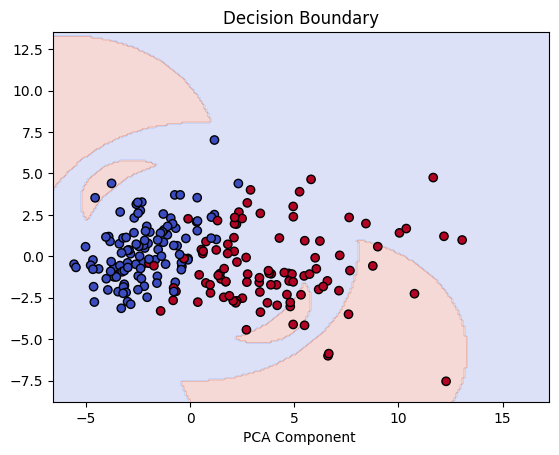

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE

# Step 1: Load the dataset
df = pd.read_csv('/content/data.csv')

# Step 2: Preprocessing
df.drop(['id', 'Unnamed: 32'], axis=1, inplace=True)  # Drop ID and unwanted column
df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': 0})  # Encode diagnosis (M = 1, B = 0)

# Separate features and target
X = df.drop('diagnosis', axis=1).values
y = df['diagnosis'].values

# Handle missing values by imputing with the mean
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Apply PCA (Increase components to preserve more variance)
pca = PCA(n_components=10)  # Changed to 10 for better representation
X_pca = pca.fit_transform(X_scaled)

# Apply SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_pca, y)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=42)

# Signal Mapping Function
def signal_mapping(X):
    """
    Map features into danger, safe, and novelty signals.
    """
    danger_signals = np.sum(X, axis=1)
    safe_signals = np.sum(X ** 2, axis=1)
    novelty_signals = np.abs(X[:, 0] - X[:, 1])
    return danger_signals, safe_signals, novelty_signals

# Signal Fusion Function
def signal_fusion(ss, ds, w11, w12, w21, w22):
    csm = w11 * ss + w12 * ds  # Cumulative signal matrix (csm)
    k = w21 * ss + w22 * ds    # Anomalous signal (k)
    return csm, k

# Dendritic Cell Algorithm
class DendriticCell:
    def __init__(self, lifespan=5):
        self.lifespan = lifespan
        self.csm = 0
        self.k = 0

    def process_signal(self, ss, ds, w11, w12, w21, w22):
        csm, k = signal_fusion(ss, ds, w11, w12, w21, w22)
        self.lifespan -= abs(csm)
        self.csm += csm
        self.k += k
        return self.lifespan

    def is_mature(self):
        return self.lifespan <= 0

# T-Cell Algorithm
class TCell:
    def __init__(self, threshold=2):
        self.k = 0
        self.threshold = threshold

    def process_antigen(self, csm, ns):
        self.k += csm + ns

    def classify_antigen(self):
        return 1 if self.k > self.threshold else 0

# Optimized gradient descent with batch processing
def optimize_weights(X_train, y_train, iterations=30, alpha=0.001, batch_size=16):  # Increased iterations, decreased learning rate
    w11, w12, w21, w22 = np.random.rand(4)
    n = X_train.shape[0]
    errors = []

    for iteration in range(iterations):
        total_error = 0

        for start in range(0, n, batch_size):
            end = start + batch_size
            batch_X = X_train[start:end]
            batch_y = y_train[start:end]

            batch_error = 0
            for i in range(batch_X.shape[0]):
                ss, ds, ns = signal_mapping(batch_X[i].reshape(1, -1))
                dc = DendriticCell()
                tc = TCell()

                step = 0
                while not dc.is_mature():
                    step += 1
                    dc.process_signal(ss, ds, w11, w12, w21, w22)
                    if step > 10:
                        break

                tc.process_antigen(dc.csm, ns)
                prediction = tc.classify_antigen()

                error = prediction - batch_y[i]
                batch_error += error ** 2

                w11 -= alpha * error * ss
                w12 -= alpha * error * ds
                w21 -= alpha * error * ss
                w22 -= alpha * error * ds

            total_error += batch_error
        errors.append(total_error)

    return w11, w12, w21, w22, errors

# Classify data using DC and TC algorithms
def classify(X_test, w11, w12, w21, w22):
    predictions = []
    for i in range(X_test.shape[0]):
        ss, ds, ns = signal_mapping(X_test[i].reshape(1, -1))
        dc = DendriticCell()
        tc = TCell()

        step = 0
        while not dc.is_mature():
            step += 1
            dc.process_signal(ss, ds, w11, w12, w21, w22)
            if step > 10:
                break

        tc.process_antigen(dc.csm, ns)
        prediction = tc.classify_antigen()
        predictions.append(prediction)
    return np.array(predictions)

# Train the model and evaluate performance
w11, w12, w21, w22, errors = optimize_weights(X_train, y_train, iterations=30, alpha=0.001, batch_size=16)

# Classify the test data
y_pred = classify(X_test, w11, w12, w21, w22)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy * 100:.2f}%")

# Confusion Matrix and Classification Report
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Plot 1: Decision Boundary
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
Z = classify(np.c_[xx.ravel(), yy.ravel()], w11, w12, w21, w22)
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.2, cmap='coolwarm')
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='coolwarm', edgecolors='k')
plt.title('Decision Boundary')
plt.xlabel('PCA Component ')


TRY--COCKY

In [ ]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE

# Step 1: Load the dataset and preprocess
df = pd.read_csv('/content/data.csv')
df.drop(['id', 'Unnamed: 32'], axis=1, inplace=True)  # Drop unnecessary columns
df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': 0})  # Encode 'diagnosis'

# Separate features and target
X = df.drop('diagnosis', axis=1).values
y = df['diagnosis'].values

# Handle missing values using SimpleImputer
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Step 2: Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Step 3: Apply PCA for dimensionality reduction
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_scaled)

# Step 4: Apply SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_pca, y)

# Step 5: Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=42)

# Signal Mapping Function
def signal_mapping(X):
    danger_signals = np.sum(X, axis=1)  # Summed values represent danger signals
    safe_signals = np.sum(X ** 2, axis=1)  # Squared values represent safe signals
    novelty_signals = np.abs(X[:, 0] - X[:, 1])  # Novelty is based on difference between the first two PCA components
    return danger_signals, safe_signals, novelty_signals

# Signal Fusion Function
def signal_fusion(ss, ds, w11, w12, w21, w22):
    csm = w11 * ss + w12 * ds  # Cumulative Signal Map
    k = w21 * ss + w22 * ds    # Anomalous Signal
    return csm, k

# Dendritic Cell Algorithm
class DendriticCell:
    def __init__(self, lifespan=5):
        self.lifespan = lifespan
        self.csm = 0
        self.k = 0

    def process_signal(self, ss, ds, w11, w12, w21, w22):
        csm, k = signal_fusion(ss, ds, w11, w12, w21, w22)
        self.lifespan -= abs(csm)
        self.csm += csm
        self.k += k
        return self.lifespan

    def is_mature(self):
        return self.lifespan <= 0

# T-Cell Algorithm
class TCell:
    def __init__(self, threshold=3):
        self.k = 0
        self.threshold = threshold

    def process_antigen(self, csm, ns):
        self.k += csm + ns

    def classify_antigen(self):
        return 1 if self.k > self.threshold else 0

# Gradient Descent for Weight Optimization
def optimize_weights(X_train, y_train, iterations=30, alpha=0.001, batch_size=16):
    w11, w12, w21, w22 = np.random.rand(4)  # Random weight initialization
    n = X_train.shape[0]

    for iteration in range(iterations):
        total_error = 0

        for start in range(0, n, batch_size):
            end = start + batch_size
            batch_X = X_train[start:end]
            batch_y = y_train[start:end]

            batch_error = 0
            for i in range(batch_X.shape[0]):
                ss, ds, ns = signal_mapping(batch_X[i].reshape(1, -1))
                dc = DendriticCell()
                tc = TCell()

                step = 0
                while not dc.is_mature():
                    step += 1
                    dc.process_signal(ss, ds, w11, w12, w21, w22)
                    if step > 10:
                        break

                tc.process_antigen(dc.csm, ns)
                prediction = tc.classify_antigen()

                error = prediction - batch_y[i]
                batch_error += error ** 2

                # Update weights using gradient descent
                w11 -= alpha * error * ss
                w12 -= alpha * error * ds
                w21 -= alpha * error * ss
                w22 -= alpha * error * ds

            total_error += batch_error

    return w11, w12, w21, w22

# Classification Function
def classify(X_test, w11, w12, w21, w22):
    predictions = []
    for i in range(X_test.shape[0]):
        ss, ds, ns = signal_mapping(X_test[i].reshape(1, -1))
        dc = DendriticCell()
        tc = TCell()

        step = 0
        while not dc.is_mature():
            step += 1
            dc.process_signal(ss, ds, w11, w12, w21, w22)
            if step > 10:
                break

        tc.process_antigen(dc.csm, ns)
        prediction = tc.classify_antigen()
        predictions.append(prediction)
    return np.array(predictions)

# Train the model and optimize weights
w11, w12, w21, w22 = optimize_weights(X_train, y_train, iterations=30, alpha=0.001, batch_size=16)

# Classify the test data
y_pred = classify(X_test, w11, w12, w21, w22)

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy * 100:.2f}%")

# Confusion Matrix and Classification Report
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Save predictions to CSV
df_predictions = pd.DataFrame({
    'predicted_outcome_binary': y_pred,
    'predicted_outcome_M_B': ['M' if pred == 1 else 'B' for pred in y_pred],
    'mapped_diagnosis_binary': y_test,
    'mapped_diagnosis_M_B': ['M' if true == 1 else 'B' for true in y_test]
})

df_predictions.to_csv('output_predictions.csv', index=False)
print("Results saved to 'output_predictions.csv'.")



Accuracy: 54.42%

Confusion Matrix:
[[113   0]
 [ 98   4]]

Classification Report:
              precision    recall  f1-score   support

           0       0.54      1.00      0.70       113
           1       1.00      0.04      0.08       102

    accuracy                           0.54       215
   macro avg       0.77      0.52      0.39       215
weighted avg       0.76      0.54      0.40       215

Results saved to 'output_predictions.csv'.


try -- please

In [ ]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import tensorflow as tf

# Step 1: Load and preprocess the dataset
df = pd.read_csv('/content/data.csv')
df.drop(['id', 'Unnamed: 32'], axis=1, inplace=True)  # Remove unnecessary columns
df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': 0})  # Encode diagnosis

# Step 2: Preprocessing
X = df.drop('diagnosis', axis=1).values  # Features
y = df['diagnosis'].values  # Target (diagnosis)

# Handle missing values with mean imputation
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Apply PCA to reduce dimensionality and capture key features
pca = PCA(n_components=10)  # Capture 10 key components for the anomaly detection
X_pca = pca.fit_transform(X_scaled)

# Apply SMOTE to balance the dataset (as malignant and benign data may be imbalanced)
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_pca, y)

# Split the data into training and test sets (70-30 split)
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=42)

# Step 3: Signal Mapping Function
def signal_mapping(X):
    danger_signals = np.sum(X, axis=1)
    safe_signals = np.sum(X ** 2, axis=1)
    novelty_signals = np.abs(X[:, 0] - X[:, 1])
    return danger_signals, safe_signals, novelty_signals

# Step 4: Signal Fusion Function
def signal_fusion(ss, ds, w11, w12, w21, w22):
    csm = w11 * ss + w12 * ds  # Calculate cumulative signal map (CSM)
    k = w21 * ss + w22 * ds    # Calculate anomaly score (K)
    return csm, k

# Step 5: Dendritic Cell Algorithm
class DendriticCell:
    def __init__(self, lifespan=5, max_steps=10):  # Set a max step count to avoid infinite loops
        self.lifespan = lifespan
        self.csm = 0
        self.k = 0
        self.max_steps = max_steps

    def process_signal(self, ss, ds, w11, w12, w21, w22):
        step = 0
        while step < self.max_steps and self.lifespan > 0:
            csm, k = signal_fusion(ss, ds, w11, w12, w21, w22)
            self.lifespan -= abs(csm)
            self.csm += csm
            self.k += k
            step += 1
        return self.lifespan

    def is_mature(self):
        return self.lifespan <= 0

# Step 6: T-Cell Algorithm
class TCell:
    def __init__(self, threshold=3):  # Lower threshold for improved sensitivity
        self.k = 0
        self.threshold = threshold

    def process_antigen(self, csm, ns):
        self.k += csm + ns

    def classify_antigen(self):
        return 1 if self.k > self.threshold else 0

# Step 7: Adam Optimizer for Weight Updates (Using TensorFlow)
def optimize_weights_adam(X_train, y_train, iterations=30, alpha=0.001, batch_size=16):
    w11 = tf.Variable(np.random.rand(), dtype=tf.float32)
    w12 = tf.Variable(np.random.rand(), dtype=tf.float32)
    w21 = tf.Variable(np.random.rand(), dtype=tf.float32)
    w22 = tf.Variable(np.random.rand(), dtype=tf.float32)

    optimizer = tf.keras.optimizers.Adam(learning_rate=alpha)
    n = X_train.shape[0]

    for iteration in range(iterations):
        total_error = 0
        for start in range(0, n, batch_size):
            end = start + batch_size
            batch_X = X_train[start:end]
            batch_y = y_train[start:end]

            batch_error = 0
            for i in range(batch_X.shape[0]):
                ss, ds, ns = signal_mapping(batch_X[i].reshape(1, -1))
                dc = DendriticCell()
                tc = TCell()

                # Process signals with DC
                dc.process_signal(ss, ds, w11, w12, w21, w22)

                # Process antigens with TC
                tc.process_antigen(dc.csm, ns)
                prediction = tc.classify_antigen()

                error = prediction - batch_y[i]
                batch_error += error ** 2

                # Update weights using Adam optimizer
                with tf.GradientTape() as tape:
                    csm, k = signal_fusion(ss, ds, w11, w12, w21, w22)
                    gradients = tape.gradient(k, [w11, w12, w21, w22])
                optimizer.apply_gradients(zip(gradients, [w11, w12, w21, w22]))

            total_error += batch_error

    return w11.numpy(), w12.numpy(), w21.numpy(), w22.numpy()

# Step 8: Classification Function
def classify(X_test, w11, w12, w21, w22):
    predictions = []
    for i in range(X_test.shape[0]):
        ss, ds, ns = signal_mapping(X_test[i].reshape(1, -1))
        dc = DendriticCell()
        tc = TCell()

        # Process signal with DC
        dc.process_signal(ss, ds, w11, w12, w21, w22)

        # Classify antigen with TC
        tc.process_antigen(dc.csm, ns)
        prediction = tc.classify_antigen()
        predictions.append(prediction)
    return np.array(predictions)

# Step 9: Train the model and optimize weights using Adam optimizer
w11, w12, w21, w22 = optimize_weights_adam(X_train, y_train, iterations=30, alpha=0.001, batch_size=16)

# Step 10: Classify the test data
y_pred = classify(X_test, w11, w12, w21, w22)

# Step 11: Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy * 100:.2f}%")

# Confusion Matrix and Classification Report
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Step 12: Save predictions to CSV
df_predictions = pd.DataFrame({
    'predicted_outcome_binary': y_pred,
    'predicted_outcome_M_B': ['M' if pred == 1 else 'B' for pred in y_pred],
    'mapped_diagnosis_binary': y_test,
    'mapped_diagnosis_M_B': ['M' if true == 1 else 'B' for true in y_test]
})

df_predictions.to_csv('output_predictions.csv', index=False)
print("Results saved to 'output_predictions.csv'.")

# Step 13: (Optional) Plot Decision Boundary (if 2D visualization is required)
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
Z = classify(np.c_[xx.ravel(), yy.ravel()], w11, w12, w21, w22)
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.2, cmap='coolwarm')
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='coolwarm', edgecolors='k')
plt.title('Decision Boundary')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()


/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:664: UserWarning: Gradients do not exist for variables ['Variable:0', 'Variable:0'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


KeyboardInterrupt: 